# Построение выборки для модели кредитного скоринга - 1 (разведочный анализ + WOE)

Загрузим данные соревнования https://www.kaggle.com/c/home-credit-default-risk/overview

In [1]:
# ! kaggle competitions download -c home-credit-default-risk

In [2]:
# ! mkdir data

In [3]:
# import zipfile
# with zipfile.ZipFile("home-credit-default-risk.zip","r") as zip_ref:
#     zip_ref.extractall("data")

In [4]:
import pandas as pd
import numpy as np

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Посмотрим на данные. Отметим, что признаков очень много: 122.

In [6]:
application = pd.read_csv('data/application_train.csv')
application.sample(7, random_state=57)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
170430,297531,0,Cash loans,M,Y,N,0,157500.0,679500.0,27076.5,679500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.026392,-14705,-7272,-6238.0,-220,8.0,1,1,0,1,1,0,Drivers,2.0,2,2,SATURDAY,17,0,0,0,0,0,0,Industry: type 7,0.342672,0.570747,0.332851,0.1206,NaN,0.9916,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1478,NaN,0.0037,0.1229,NaN,0.9916,NaN,NaN,0.1611,0.1379,0.3333,NaN,NaN,NaN,0.1540,NaN,0.0039,0.1218,NaN,0.9916,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1504,NaN,0.0037,NaN,block of flats,0.1170,Others,No,0.0,0.0,0.0,0.0,-2252.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
77136,189440,0,Cash loans,F,Y,Y,0,220500.0,432567.0,19183.5,328500.0,Family,Working,Secondary / secondary special,Separated,House / apartment,0.018029,-20590,-708,-1768.0,-4081,11.0,1,1,0,1,0,0,Laborers,1.0,3,3,TUESDAY,13,0,0,0,0,0,0,Government,0.788965,0.090318,0.764939,0.0722,NaN,0.9846,NaN,NaN,0.00,0.0345,0.2083,NaN,NaN,NaN,0.0422,NaN,0.0000,0.0735,NaN,0.9846,NaN,NaN,0.0000,0.0345,0.2083,NaN,NaN,NaN,0.0439,NaN,0.0000,0.0729,NaN,0.9846,NaN,NaN,0.00,0.0345,0.2083,NaN,NaN,NaN,0.0429,NaN,0.0000,NaN,block of flats,0.0395,Panel,No,0.0,0.0,0.0,0.0,-119.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,7.0
236101,373468,0,Cash loans,F,Y,Y,0,90000.0,254700.0,14350.5,225000.0,Family,Pensioner,Secondary / secondary special,Married,House / apartment,0.035792,-23878,365243,-9575.0,-4358,15.0,1,0,0,1,1,0,NaN,2.0,2,2,MONDAY,13,0,0,0,1,0,0,XNA,0.841625,0.295620,0.656158,0.0897,NaN,0.9816,NaN,NaN,NaN,0.2069,0.1667,NaN,0.0908,NaN,0.0766,NaN,0.0098,0.0914,NaN,0.9816,NaN,NaN,NaN,0.2069,0.1667,NaN,0.0928,NaN,0.0799,NaN,0.0104,0.0906,NaN,0.9816,NaN,NaN,NaN,0.2069,0.1667,NaN,0.0923,NaN,0.0780,NaN,0.0100,NaN,block of flats,0.0700,"Stone, bric

In [7]:
application.shape

(307511, 122)

С таким большим количеством колонок работать неудобно. Разобьем их на группы.

In [8]:
FLAG_DOCUMENT_GROUP = ['FLAG_DOCUMENT_%s' % i for i in range(2, 22)]
TARGET_GROUP = ['TARGET']
GENERAL_BIO_GROUP = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                     'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                     'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
                     'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                     'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'ORGANIZATION_TYPE',
                     'OWN_CAR_AGE', 'DAYS_LAST_PHONE_CHANGE']
DAYS_BIO_GROUP = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']
AMT_GROUP = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'] + [
    'AMT_REQ_CREDIT_BUREAU_%s' % i for i in ['HOUR', 'DAY', 'WEEK', 'MON', 'QRT', 'YEAR']]
REGION_GROUP = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 
                'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
                'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'REGION_POPULATION_RELATIVE']
APARTMENT_GROUP = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
                   'COMMONAREA_AVG', 'ELEVATORS_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
                   'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
                   'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
                   'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
                   'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
                   'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
                   'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
                   'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
                   'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
                   'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
                   'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
SOCIAL_CIRCLE_GROUP = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
APPR_PROCESS_GROUP = ['HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START']
EXT_SOURCE_GROUP = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
OTHER_GROUP = ['ENTRANCES_AVG', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE']
USELESS_FEATURES = []


In [9]:
ALL_COLUMNS = set(application.columns)
COLUMNS_IN_GROUPS = FLAG_DOCUMENT_GROUP + TARGET_GROUP + GENERAL_BIO_GROUP + DAYS_BIO_GROUP +\
                    AMT_GROUP + REGION_GROUP + APARTMENT_GROUP + SOCIAL_CIRCLE_GROUP +\
                    APPR_PROCESS_GROUP + EXT_SOURCE_GROUP + OTHER_GROUP
print(len(ALL_COLUMNS) == len(COLUMNS_IN_GROUPS), len(ALL_COLUMNS), len(COLUMNS_IN_GROUPS))
print(set(COLUMNS_IN_GROUPS) == set(ALL_COLUMNS), set(ALL_COLUMNS) - set(COLUMNS_IN_GROUPS))

True 122 122
True set()


Посмотрим на различные общие статистики по данным

In [10]:
column_statistics = pd.DataFrame(index=application.columns)
column_statistics['CountNaN'] = application.isna().sum()
column_statistics['RateNaN%'] = (application.isna().sum() / application.shape[0] * 100).astype(int)
column_statistics['CountUnique'] = application.nunique()
described = application.describe()
column_statistics['MinValue'] = described.loc['min']
column_statistics['MaxValue'] = described.loc['max']
column_statistics['Mean'] = described.loc['mean']
column_statistics['Std'] = described.loc['std']
column_statistics['Median'] = described.loc['50%']

In [11]:
column_statistics

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
SK_ID_CURR,0,0,307511,1.000020e+05,4.562550e+05,278180.518577,102790.175348,278202.000000
TARGET,0,0,2,0.000000e+00,1.000000e+00,0.080729,0.272419,0.000000
NAME_CONTRACT_TYPE,0,0,2,NaN,NaN,NaN,NaN,NaN
CODE_GENDER,0,0,3,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,0,0,2,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,0,0,2,NaN,NaN,NaN,NaN,NaN
CNT_CHILDREN,0,0,15,0.000000e+00,1.900000e+01,0.417052,0.722121,0.000000
AMT_INCOME_TOTAL,0,0,2548,2.565000e+04,1.170000e+08,168797.919297,237123.146279,147150.000000
AMT_CREDIT,0,0,5603,4.500000e+04,4.050000e+06,599025.999706,402490.776996,513531.000000
AMT_ANNUITY,12,0,13672,1.615500e+03,2.580255e+05,27108.573909,14493.737315,24903.000000


In [12]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

Функции для составления/визуализации статистик

In [13]:
def draw_pies_for_columns(columns, dff):
    for col in columns:
        counts = Counter(dff[col])
        df = pd.DataFrame.from_dict(counts, orient='index')
        df.index.name = col
        df.columns = ['count']
        df.plot(kind='pie', rot=0, figsize=(5, 5), y='count', autopct='%1.1f%%')
        plt.title('Data distribution by %s' % col)
        plt.xlabel(col)
        plt.ylabel('count')
        plt.show()
        
def draw_hists_for_categorical_columns(columns, dff):
    for col in columns:
        counts = Counter(dff[col])
        df = pd.DataFrame.from_dict(counts, orient='index')
        df.index.name = col
        df.columns = ['count']
        df.plot(kind='bar', rot=90, figsize=(15,4))
        plt.title('Data distribution by %s' % col)
        plt.xlabel(col)
        plt.ylabel('count')
        plt.show()
        
def draw_hists_for_numerical_columns(columns, dff):
    for col in columns:
        plt.figure(figsize=(16,6))
        plt.hist(dff[col], bins=50)
        plt.title('Data distribution by %s' % col)
        plt.xlabel(col)
        plt.show()

def draw_correlations_for_numerical_columns(columns, dff):
    plt.figure(figsize=(18, 18))
    cor = dff[columns].corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()

def get_df_general_stats(df):
    column_statistics = pd.DataFrame(index=df.columns)
    column_statistics['CountNaN'] = df.isna().sum()
    column_statistics['RateNaN%'] = (df.isna().sum() / df.shape[0] * 100).astype(int)
    column_statistics['CountUnique'] = df.nunique()
    described = df.describe()
    column_statistics['MinValue'] = described.loc['min']
    column_statistics['MaxValue'] = described.loc['max']
    column_statistics['Mean'] = described.loc['mean']
    column_statistics['Std'] = described.loc['std']
    column_statistics['Median'] = described.loc['50%']
    return column_statistics

С данными целиком работать сложно, поэтому для начала посмотрим на различные группы.

## Анализ групп признаков

### GENERAL_BIO_GROUP - общие признаки клиента

In [14]:
general_bio_application = application[GENERAL_BIO_GROUP]

In [15]:
general_bio_application.sample(7, random_state=57)

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,OWN_CAR_AGE,DAYS_LAST_PHONE_CHANGE
170430,M,Y,N,0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Drivers,1,1,0,1,1,0,2.0,Industry: type 7,8.0,-2252.0
77136,F,Y,Y,0,Family,Working,Secondary / secondary special,Separated,House / apartment,Laborers,1,1,0,1,0,0,1.0,Government,11.0,-119.0
236101,F,Y,Y,0,Family,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,1,0,0,1,1,0,2.0,XNA,15.0,-2400.0
139065,F,N,Y,0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,1,0,0,1,0,0,2.0,XNA,NaN,-1695.0
240305,M,Y,N,0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1,1,0,1,0,0,1.0,Trade: type 7,10.0,-1479.0
128737,M,Y,N,0,Unaccompanied,Working,Higher education,Married,With parents,Managers,1,1,1,1,0,0,2.0,Business Entity Type 3,8.0,-2747.0
37088,M,Y,Y,0,Family,Working,Secondary / secondary special,Married,House / apartment,Laborers,1,1,0,1,1,0,2.0,Business Entity Type 2,14.0,-1133.0


In [16]:
get_df_general_stats(general_bio_application)

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
CODE_GENDER,0,0,3,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,0,0,2,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,0,0,2,NaN,NaN,NaN,NaN,NaN
CNT_CHILDREN,0,0,15,0.0,19.0,0.417052,0.722121,0.0
NAME_TYPE_SUITE,1292,0,7,NaN,NaN,NaN,NaN,NaN
NAME_INCOME_TYPE,0,0,8,NaN,NaN,NaN,NaN,NaN
NAME_EDUCATION_TYPE,0,0,5,NaN,NaN,NaN,NaN,NaN
NAME_FAMILY_STATUS,0,0,6,NaN,NaN,NaN,NaN,NaN
NAME_HOUSING_TYPE,0,0,6,NaN,NaN,NaN,NaN,NaN
OCCUPATION_TYPE,96391,31,18,NaN,NaN,NaN,NaN,NaN


Признаки с пропусками в данных: NAME_TYPE_SUITE, OCCUPATION_TYPE, OWN_CAR_AGE. Посмотрим на них отдельно, чтобы понять, что лучше сделать с пропусками.

#### NAME_TYPE_SUITE

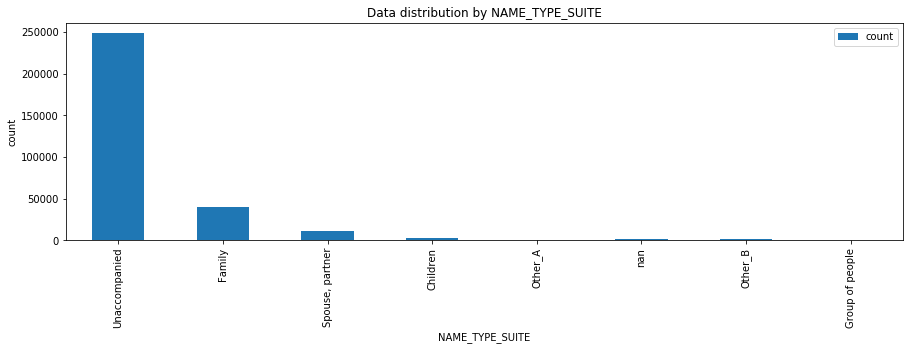

In [17]:
draw_hists_for_categorical_columns(['NAME_TYPE_SUITE'], general_bio_application)

Заметим, что во всех колонках, кроме Unaccompanied и Family очень мало клиентов.

Поэтому объединим их вместе с Family в одну колонку Accompanied.

In [18]:
def update_data_NAME_TYPE_SUITE(df):
    df.loc[df['NAME_TYPE_SUITE'] != 'Unaccompanied', 'NAME_TYPE_SUITE'] = 'Accompanied'

In [19]:
update_data_NAME_TYPE_SUITE(general_bio_application)

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


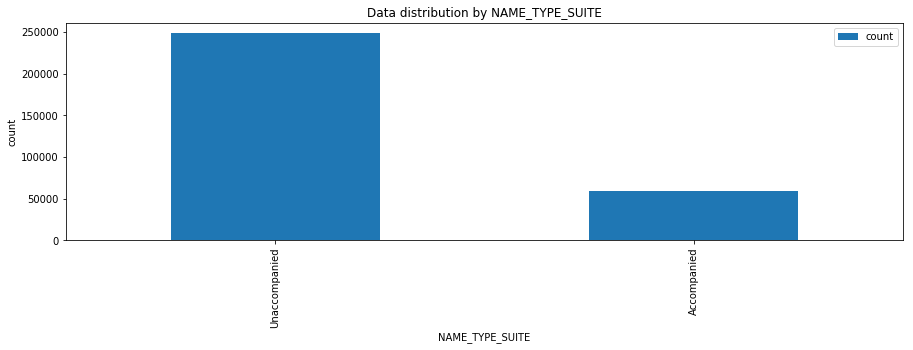

In [20]:
draw_hists_for_categorical_columns(['NAME_TYPE_SUITE'], general_bio_application)

#### OCCUPATION_TYPE

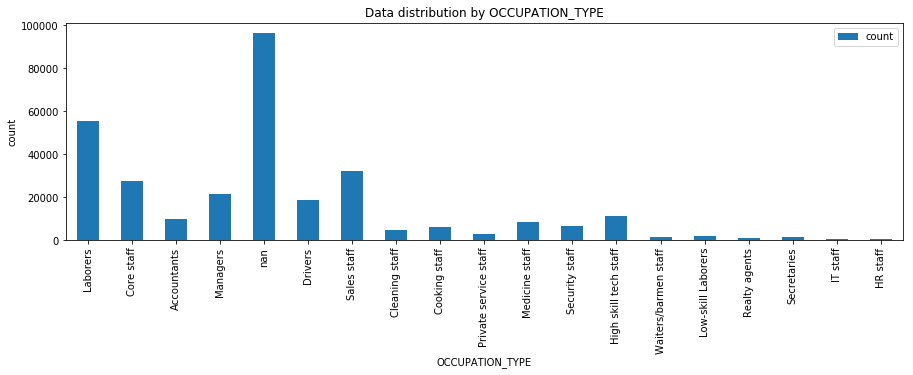

In [21]:
counts = Counter(general_bio_application['OCCUPATION_TYPE'])
df = pd.DataFrame.from_dict(counts, orient='index')
df.index.name = 'OCCUPATION_TYPE'
df.columns = ['count']
df.plot(kind='bar', rot=90, figsize=(15,4))
plt.title('Data distribution by %s' % 'OCCUPATION_TYPE')
plt.xlabel('OCCUPATION_TYPE')
plt.ylabel('count')
plt.show()

In [22]:
def update_data_OCCUPATION_TYPE(df):
    df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Other')
    df.loc[df['OCCUPATION_TYPE'] == 'Cleaning staff', 'OCCUPATION_TYPE'] = 'staff'
    df.loc[df['OCCUPATION_TYPE'] == 'Cooking staff', 'OCCUPATION_TYPE'] = 'staff'
    df.loc[df['OCCUPATION_TYPE'] == 'Private service staff', 'OCCUPATION_TYPE'] = 'staff'
    df.loc[df['OCCUPATION_TYPE'] == 'Waiters/barmen staff', 'OCCUPATION_TYPE'] = 'staff'
    df.loc[df['OCCUPATION_TYPE'] == 'Low-skill Laborers', 'OCCUPATION_TYPE'] = 'staff'
    df.loc[df['OCCUPATION_TYPE'] == 'IT staff', 'OCCUPATION_TYPE'] = 'staff'
    df.loc[df['OCCUPATION_TYPE'] == 'HR staff', 'OCCUPATION_TYPE'] = 'staff'
    df.loc[df['OCCUPATION_TYPE'] == 'Secretaries', 'OCCUPATION_TYPE'] = 'staff'
    df.loc[df['OCCUPATION_TYPE'] == 'Realty agents', 'OCCUPATION_TYPE'] = 'Other'

In [23]:
update_data_OCCUPATION_TYPE(general_bio_application)

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


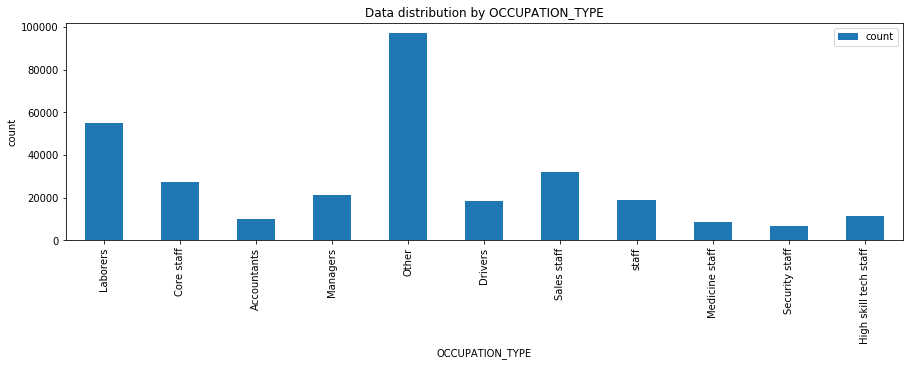

In [24]:
counts = Counter(general_bio_application['OCCUPATION_TYPE'])
df = pd.DataFrame.from_dict(counts, orient='index')
df.index.name = 'OCCUPATION_TYPE'
df.columns = ['count']
df.plot(kind='bar', rot=90, figsize=(15,4))
plt.title('Data distribution by %s' % 'OCCUPATION_TYPE')
plt.xlabel('OCCUPATION_TYPE')
plt.ylabel('count')
plt.show()

#### OWN_CAR_AGE

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


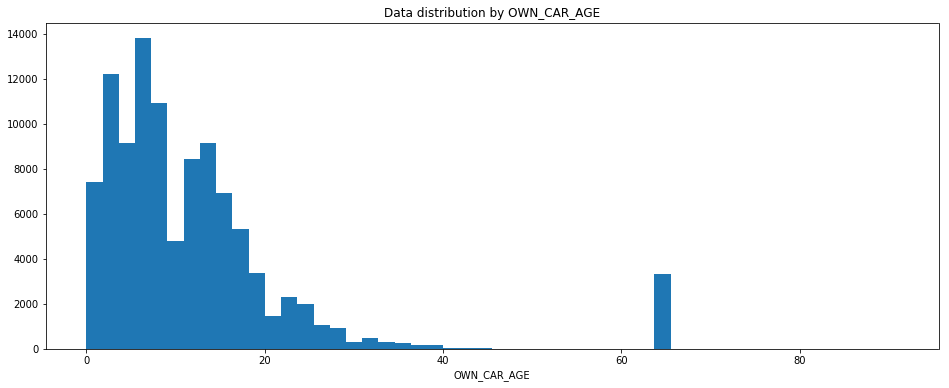

In [25]:
draw_hists_for_numerical_columns(['OWN_CAR_AGE'], general_bio_application)

Выступ между 60 и 80 выглядит подозрительно. Как мы видели, тут более 60% пропусков. Надо будет потом подробнее посмотреть, что с ними делать, так как замена их на что-либо сильно испортит распределение.

#### Остальные признаки

In [26]:
GENERAL_BIO_GROUP_CATEGORICAL_SMALL = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                     'NAME_TYPE_SUITE',
                     'NAME_FAMILY_STATUS',
                     'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                     'FLAG_PHONE', 'FLAG_EMAIL']
GENERAL_BIO_GROUP_CATEGORICAL_BIG = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'NAME_INCOME_TYPE', 
                                     'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
                                     'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
GENERAL_BIO_GROUP_NUMERIC = ['OWN_CAR_AGE', 'DAYS_LAST_PHONE_CHANGE']

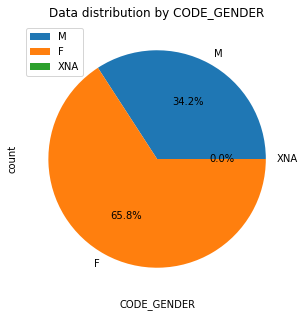

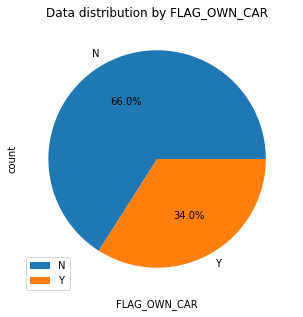

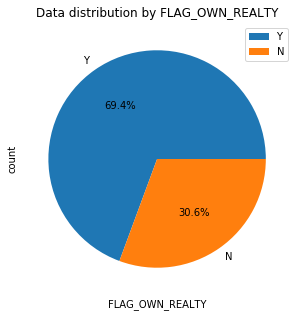

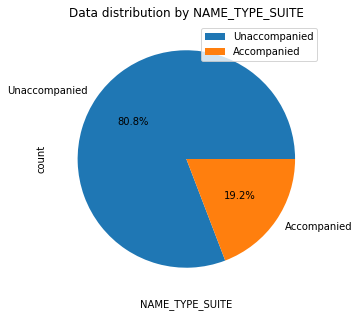

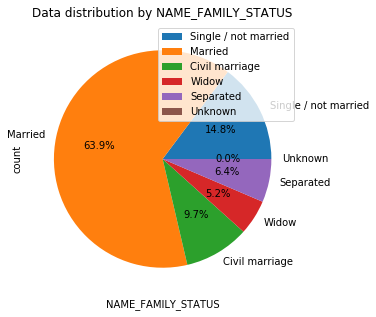

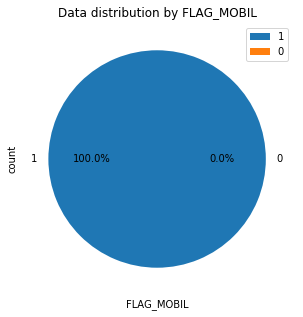

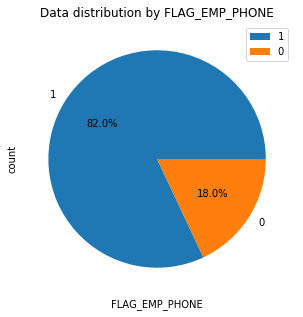

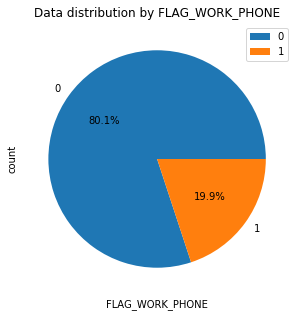

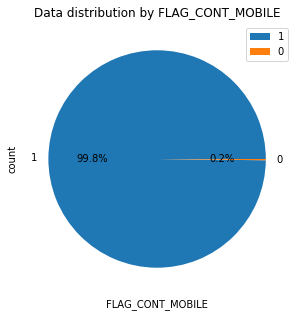

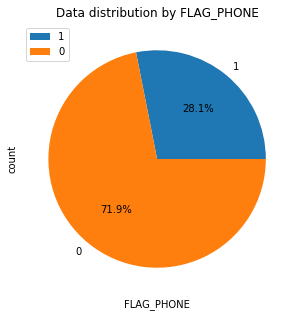

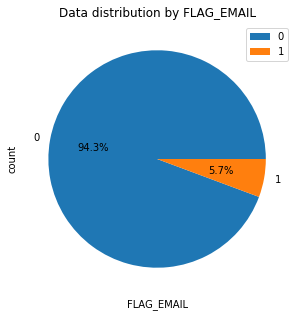

In [27]:
draw_pies_for_columns(GENERAL_BIO_GROUP_CATEGORICAL_SMALL, general_bio_application)

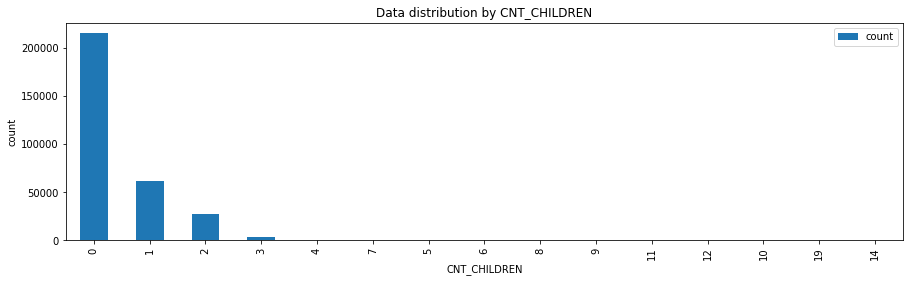

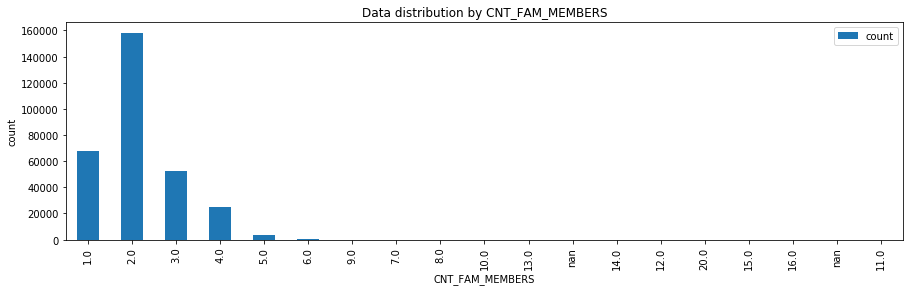

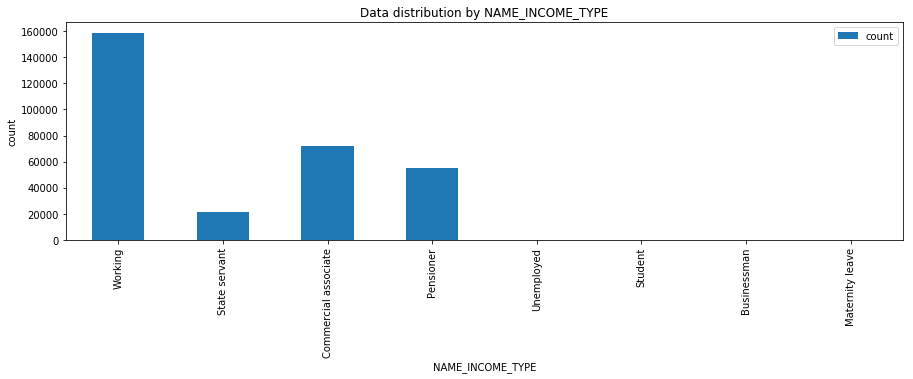

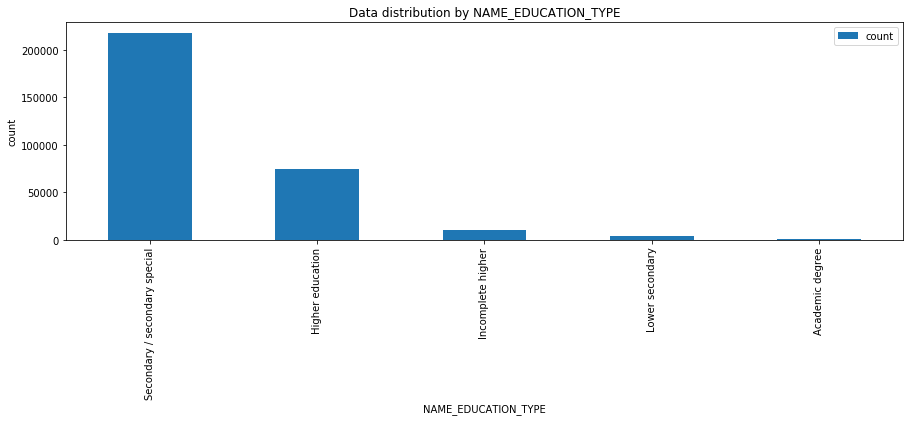

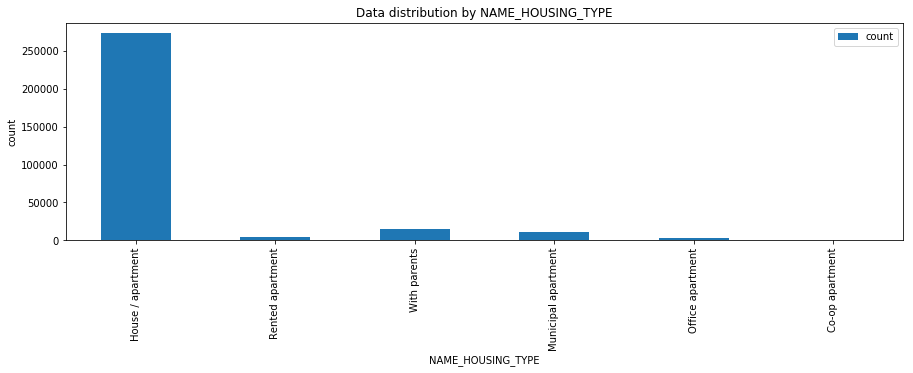

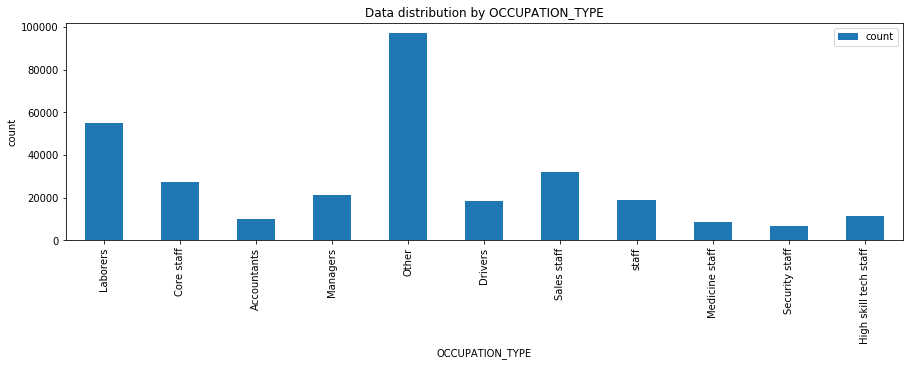

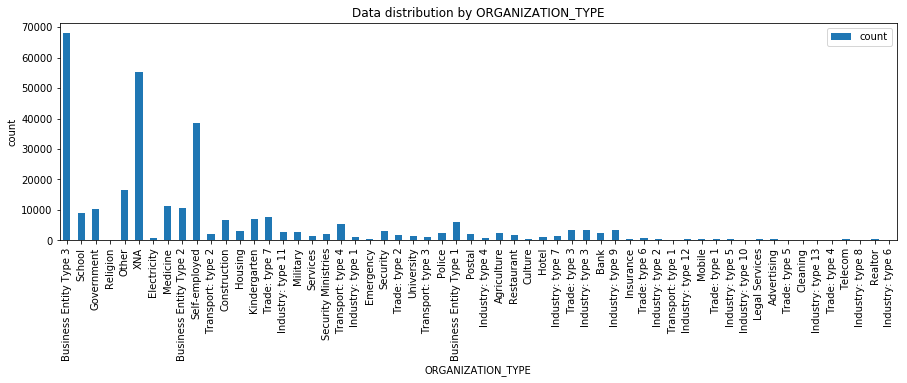

In [28]:
draw_hists_for_categorical_columns(GENERAL_BIO_GROUP_CATEGORICAL_BIG, general_bio_application)

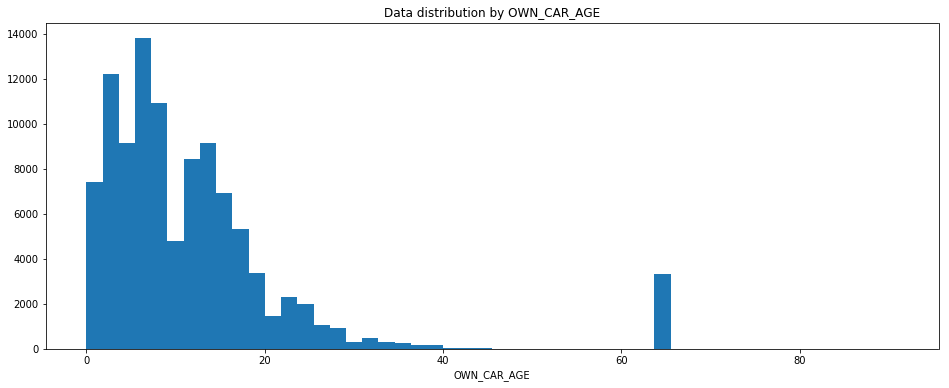

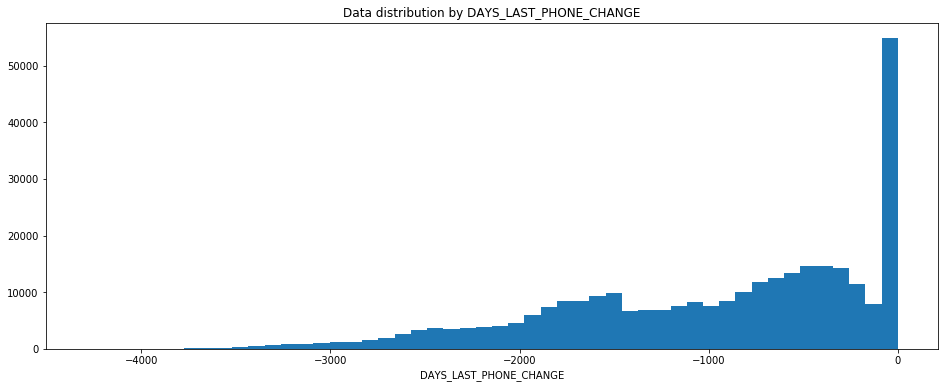

In [29]:
draw_hists_for_numerical_columns(GENERAL_BIO_GROUP_NUMERIC, general_bio_application)

Наблюдения:

1. CODE_GENDER: XNA values.
2. FLAG_OWN_CAR: надо сравнить с OWN_CAR_AGE и заменить NAN в последнем на 0.
3. NAME_FAMILY_STATUS: Unknown встречается очень малое количество раз.
4. FLAG_MOBIL: useless column
5. FLAG_CONT_MOBILE: useless column
6. CNT_CHILDREN: заменить значения на 0, 1, 2
7. CNT_FAM_MEMBERS: заменить значения на 0, 1, 2, 3, 4
8. NAME_INCOME_TYPE: 4 колонки имеют очень малое количество данных
9. NAME_EDUCATION_TYPE, NAME_HOUSING_TYPE, ORGANIZATION_TYPE: то же самое

In [30]:
general_bio_application[general_bio_application.CODE_GENDER == 'XNA']

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,OWN_CAR_AGE,DAYS_LAST_PHONE_CHANGE
35657,XNA,Y,Y,0,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,Other,1,1,1,1,1,0,2.0,Business Entity Type 1,13.0,-286.0
38566,XNA,N,Y,2,Accompanied,Working,Secondary / secondary special,Married,House / apartment,staff,1,1,1,1,1,0,4.0,Industry: type 3,NaN,-493.0
83382,XNA,N,Y,1,Unaccompanied,Working,Higher education,Married,House / apartment,Core staff,1,1,1,1,1,0,3.0,Kindergarten,NaN,-851.0
189640,XNA,Y,Y,0,Unaccompanied,Commercial associate,Incomplete higher,Civil marriage,House / apartment,Other,1,1,1,1,1,0,2.0,Medicine,8.0,-1681.0


In [31]:
def update_data_CODE_GENDER(df):
    df.loc[df['CODE_GENDER'] == 'XNA', 'CODE_GENDER'] = 'F'

In [32]:
update_data_CODE_GENDER(general_bio_application)

In [33]:
general_bio_application[general_bio_application.CODE_GENDER == 'XNA']

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,OWN_CAR_AGE,DAYS_LAST_PHONE_CHANGE


In [34]:
general_bio_application[
    (general_bio_application.FLAG_OWN_CAR == 'Y') & (general_bio_application.OWN_CAR_AGE.isna())]

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,OWN_CAR_AGE,DAYS_LAST_PHONE_CHANGE
30897,M,Y,N,1,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,1,1,1,1,0,0,2.0,Construction,NaN,-1477.0
181231,F,Y,N,0,Accompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Medicine staff,1,1,0,1,0,1,2.0,Medicine,NaN,-1705.0
217549,M,Y,N,0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Drivers,1,1,1,1,1,0,2.0,Advertising,NaN,-59.0
229867,F,Y,Y,1,Accompanied,Commercial associate,Higher education,Married,House / apartment,Accountants,1,1,0,1,0,0,3.0,Self-employed,NaN,-668.0
236868,F,Y,Y,0,Accompanied,Commercial associate,Higher education,Civil marriage,House / apartment,Other,1,1,0,1,0,0,2.0,Other,NaN,-720.0


In [35]:
def update_data_OWN_CAR_AGE(df):
    df['OWN_CAR_AGE'] = df['OWN_CAR_AGE'].fillna(0)

In [36]:
update_data_OWN_CAR_AGE(general_bio_application)

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
USELESS_FEATURES.append('FLAG_MOBIL')
USELESS_FEATURES.append('FLAG_CONT_MOBILE')

### DAYS_BIO_GROUP

In [38]:
days_bio_application = application[DAYS_BIO_GROUP]
days_bio_application.sample(7, random_state=57)

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH
170430,-14705,-7272,-6238.0,-220
77136,-20590,-708,-1768.0,-4081
236101,-23878,365243,-9575.0,-4358
139065,-22840,365243,-13328.0,-4406
240305,-10902,-1095,-2148.0,-2148
128737,-12316,-2555,-6377.0,-4566
37088,-18215,-10345,-7312.0,-1762


In [39]:
get_df_general_stats(days_bio_application)

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
DAYS_BIRTH,0,0,17460,-25229.0,-7489.0,-16036.995067,4363.988632,-15750.0
DAYS_EMPLOYED,0,0,12574,-17912.0,365243.0,63815.045904,141275.766519,-1213.0
DAYS_REGISTRATION,0,0,15688,-24672.0,0.0,-4986.120328,3522.886321,-4504.0
DAYS_ID_PUBLISH,0,0,6168,-7197.0,0.0,-2994.202373,1509.450419,-3254.0


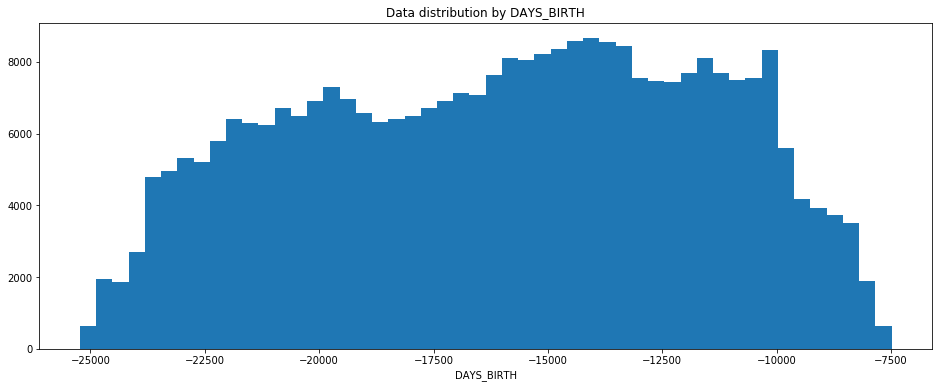

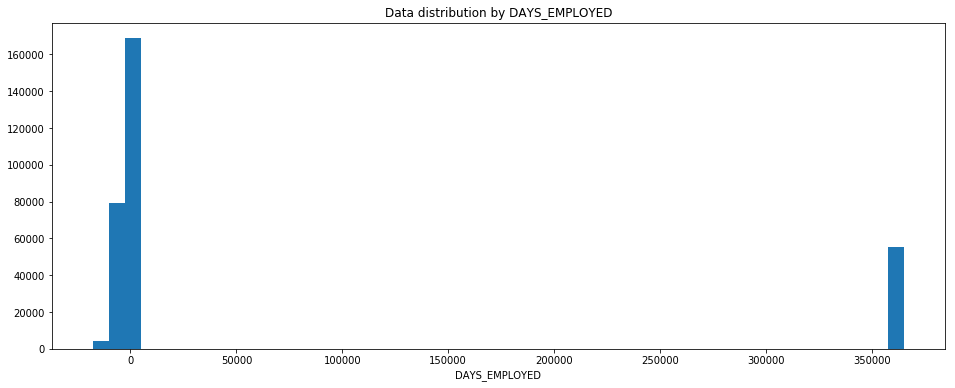

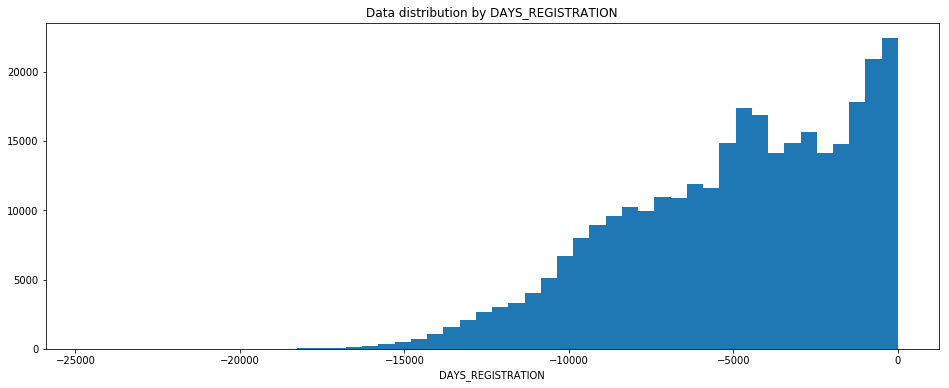

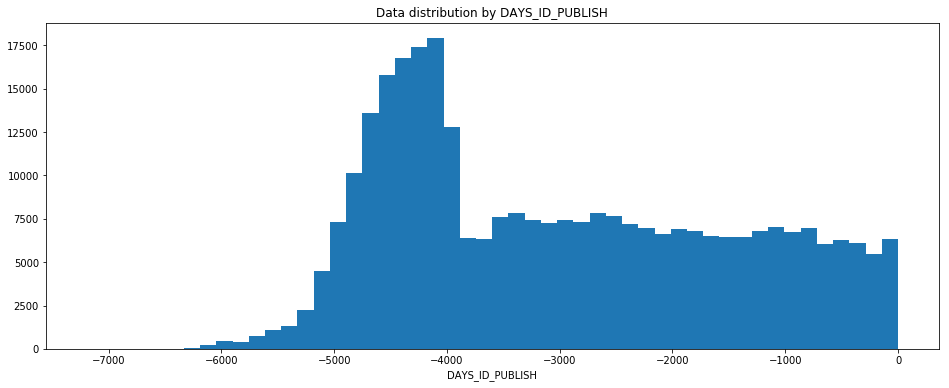

In [40]:
draw_hists_for_numerical_columns(DAYS_BIO_GROUP, days_bio_application)

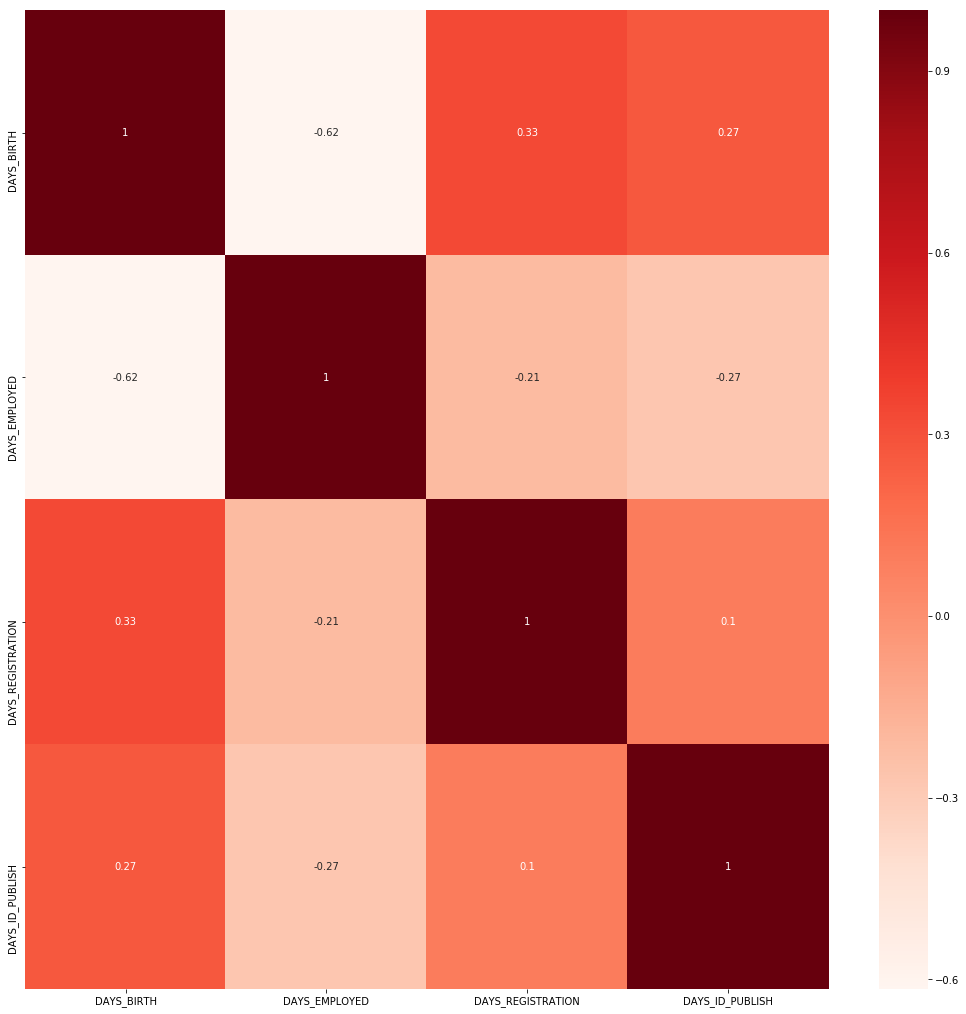

In [41]:
draw_correlations_for_numerical_columns(DAYS_BIO_GROUP, days_bio_application)

Наблюдения:

1. DAYS_EMPLOYED: очень странное распределение

### AMT_GROUP

In [42]:
amt_application = application[AMT_GROUP]
amt_application.sample(7, random_state=57)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
170430,157500.0,679500.0,27076.5,679500.0,0.0,0.0,0.0,0.0,0.0,2.0
77136,220500.0,432567.0,19183.5,328500.0,0.0,0.0,0.0,0.0,0.0,7.0
236101,90000.0,254700.0,14350.5,225000.0,0.0,0.0,0.0,0.0,0.0,0.0
139065,180000.0,724261.5,32031.0,576000.0,0.0,0.0,0.0,1.0,0.0,3.0
240305,270000.0,761949.0,51048.0,697500.0,NaN,NaN,NaN,NaN,NaN,NaN
128737,270000.0,497520.0,36054.0,450000.0,0.0,0.0,0.0,0.0,1.0,6.0
37088,135000.0,770292.0,32764.5,688500.0,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
get_df_general_stats(amt_application)

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
AMT_INCOME_TOTAL,0,0,2548,25650.0,117000000.0,168797.919297,237123.146279,147150.0
AMT_CREDIT,0,0,5603,45000.0,4050000.0,599025.999706,402490.776996,513531.0
AMT_ANNUITY,12,0,13672,1615.5,258025.5,27108.573909,14493.737315,24903.0
AMT_GOODS_PRICE,278,0,1002,40500.0,4050000.0,538396.207429,369446.460540,450000.0
AMT_REQ_CREDIT_BUREAU_HOUR,41519,13,5,0.0,4.0,0.006402,0.083849,0.0
AMT_REQ_CREDIT_BUREAU_DAY,41519,13,9,0.0,9.0,0.007000,0.110757,0.0
AMT_REQ_CREDIT_BUREAU_WEEK,41519,13,9,0.0,8.0,0.034362,0.204685,0.0
AMT_REQ_CREDIT_BUREAU_MON,41519,13,24,0.0,27.0,0.267395,0.916002,0.0
AMT_REQ_CREDIT_BUREAU_QRT,41519,13,11,0.0,261.0,0.265474,0.794056,0.0
AMT_REQ_CREDIT_BUREAU_YEAR,41519,13,25,0.0,25.0,1.899974,1.869295,1.0


In [44]:
AMT_GROUP_NUMERIC = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
AMT_GROUP_CATEGORICAL = ['AMT_REQ_CREDIT_BUREAU_%s' % i for i in ['HOUR', 'DAY', 'WEEK', 'MON', 'QRT', 'YEAR']]

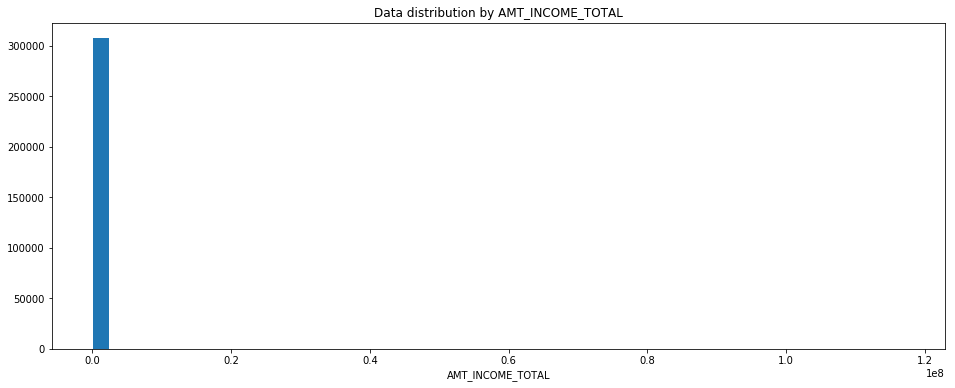

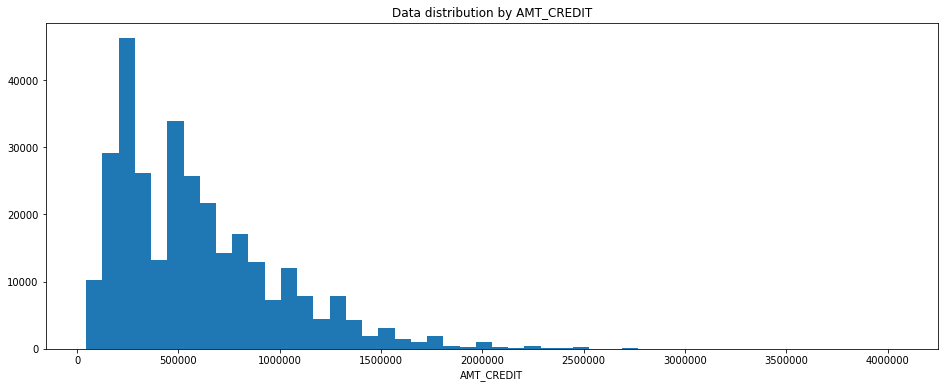

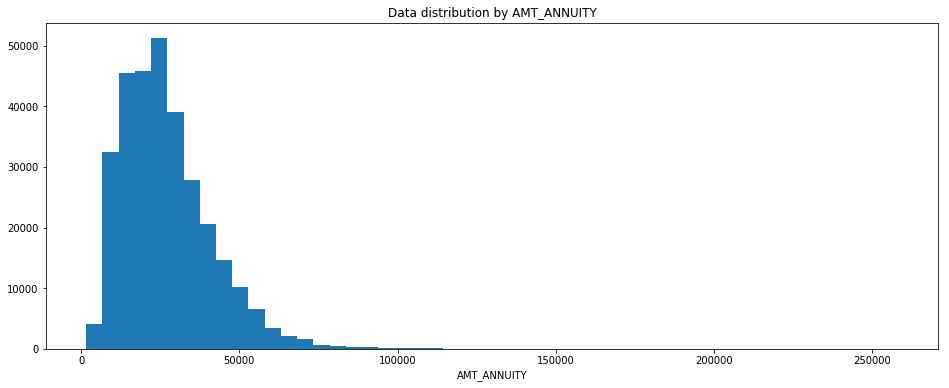

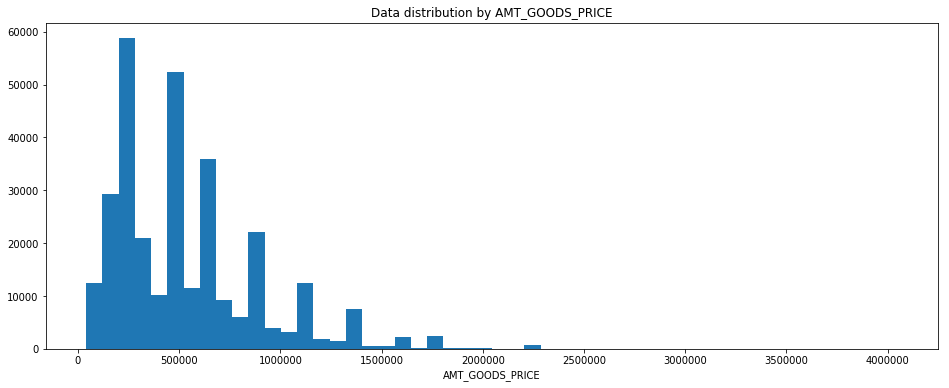

In [45]:
draw_hists_for_numerical_columns(AMT_GROUP_NUMERIC, amt_application)

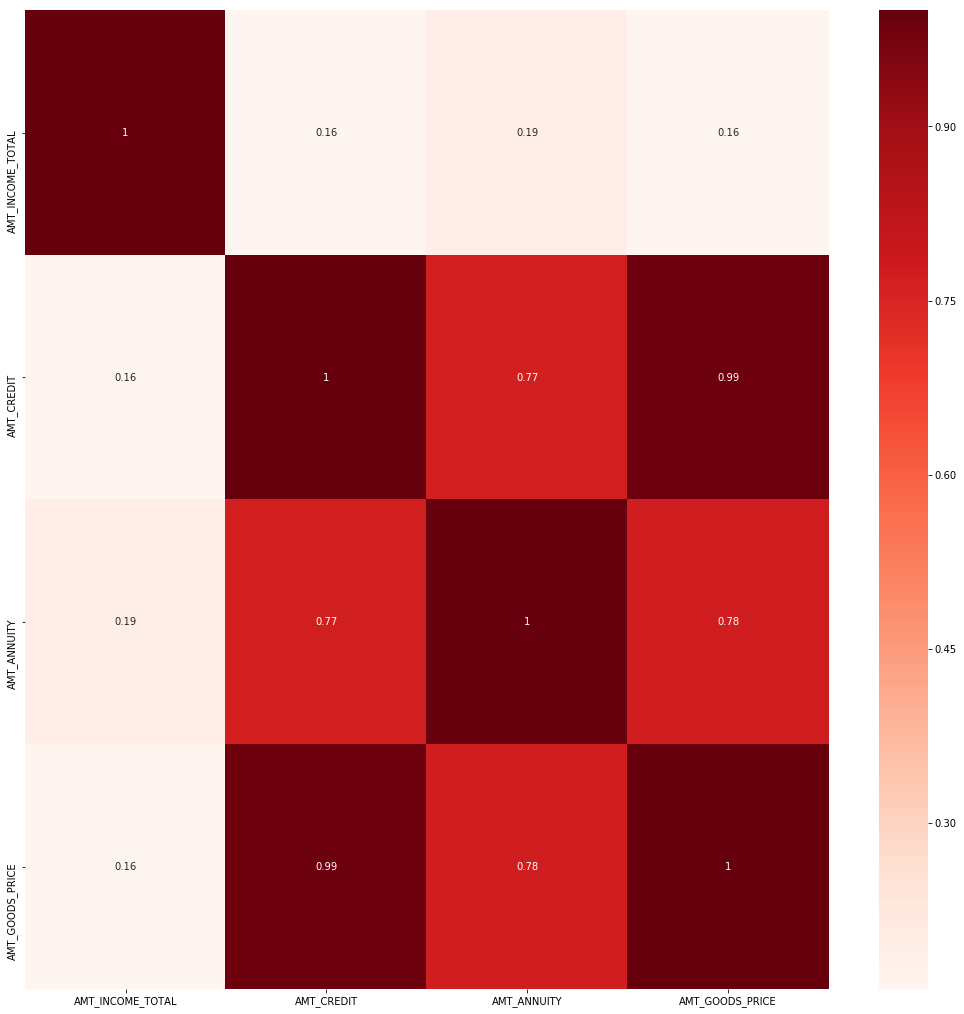

In [46]:
draw_correlations_for_numerical_columns(AMT_GROUP_NUMERIC, amt_application)

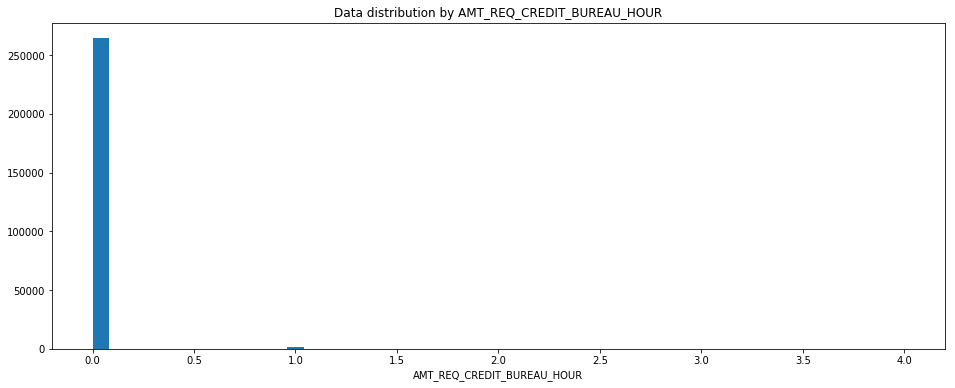

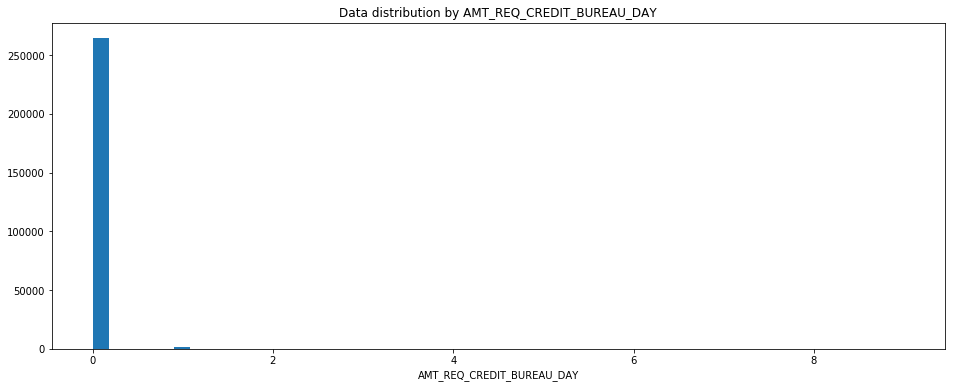

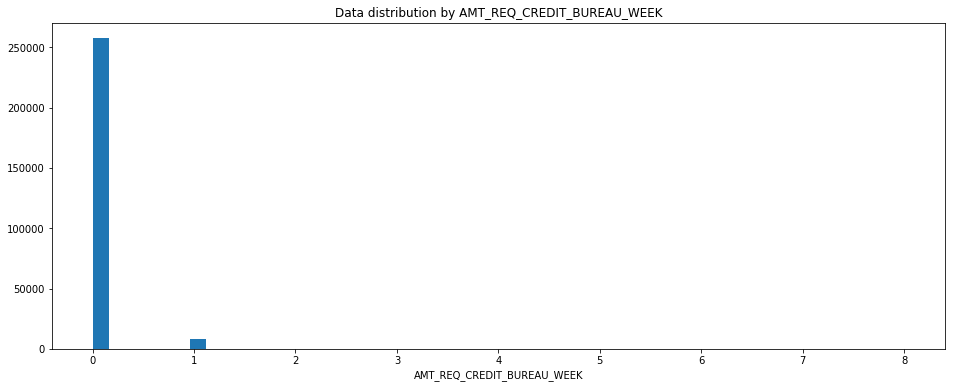

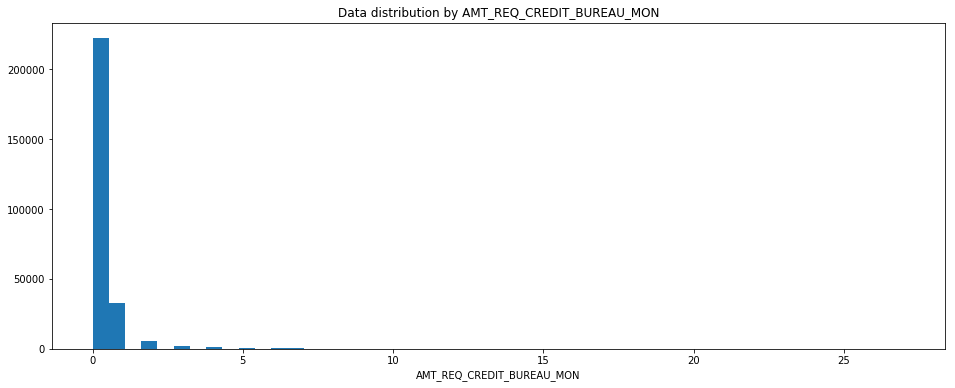

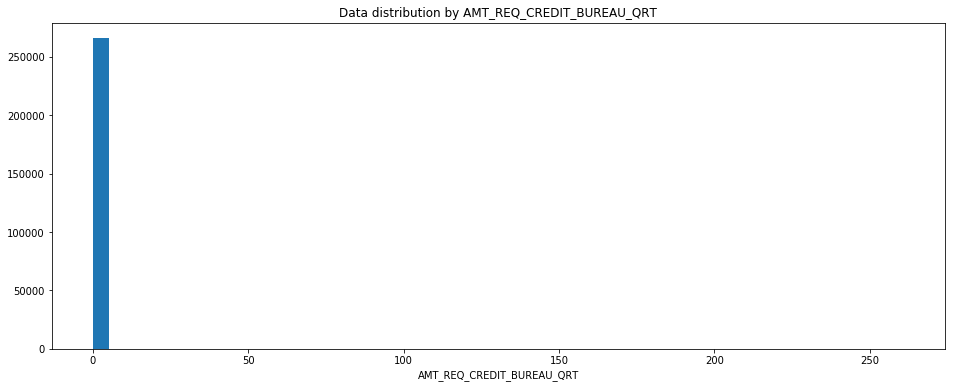

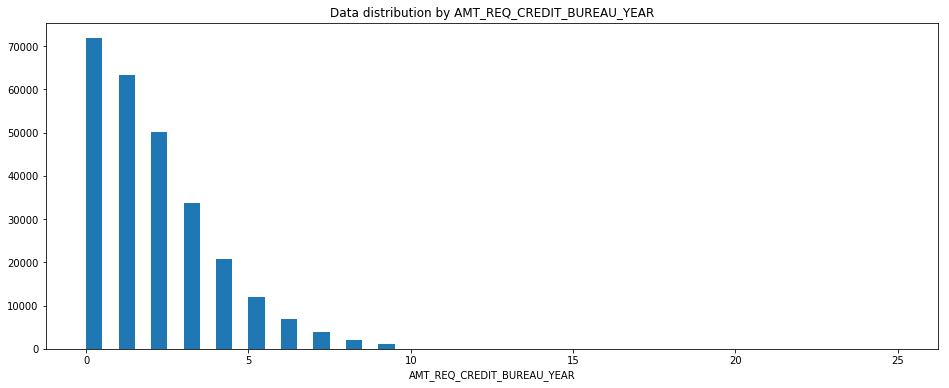

In [47]:
draw_hists_for_numerical_columns(AMT_GROUP_CATEGORICAL, amt_application)

### APARTMENT_GROUP

In [64]:
apartment_application = application[APARTMENT_GROUP]
apartment_application.sample(7, random_state=57)

,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
170430,0.1206,NaN,0.9916,NaN,NaN,0.16,0.3333,NaN,NaN,NaN,0.1478,NaN,0.0037,0.1229,NaN,0.9916,NaN,NaN,0.1611,0.1379,0.3333,NaN,NaN,NaN,0.1540,NaN,0.0039,0.1218,NaN,0.9916,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1504,NaN,0.0037,NaN,block of flats,0.1170,Others,No
77136,0.0722,NaN,0.9846,NaN,NaN,0.00,0.2083,NaN,NaN,NaN,0.0422,NaN,0.0000,0.0735,NaN,0.9846,NaN,NaN,0.0000,0.0345,0.2083,NaN,NaN,NaN,0.0439,NaN,0.0000,0.0729,NaN,0.9846,NaN,NaN,0.00,0.0345,0.2083,NaN,NaN,NaN,0.0429,NaN,0.0000,NaN,block of flats,0.0395,Panel,No
236101,0.0897,NaN,0.9816,NaN,NaN,NaN,0.1667,NaN,0.0908,NaN,0.0766,NaN,0.0098,0.0914,NaN,0.9816,NaN,NaN,NaN,0.2069,0.1667,NaN,0.0928,NaN,0.0799,NaN,0.0104,0.0906,NaN,0.9816,NaN,NaN,NaN,0.2069,0.1667,NaN,0.0923,NaN,0.0780,NaN,0.0100,NaN,block of flats,0.0700,"Stone, brick",No
139065,0.1227,0.0990,0.9816,0.7484,0.0160,0.00,0.1667,0.2083,0.0547,0.1000,0.1023,0.0000,0.0000,0.1250,0.1027,0.9816,0.7583,0.0161,0.0000,0.2759,0.1667,0.2083,0.0560,0.1093,0.1066,0.0000,0.0000,0.1239,0.0990,0.9816,0.7518,0.0161,0.00,0.2759,0.1667,0.2083,0.0557,0.1018,0.1041,0.0000,0.0000,reg oper spec account,block of flats,0.0892,Panel,No
240305,0.0608,0.0556,0.9786,0.7076,0.0471,0.00,0.1667,0.2083,0.0632,0.0488,0.0503,0.0039,0.0055,0.0620,0.0577,0.9786,0.7190,0.0475,0.0000,0.1379,0.1667,0.2083,0.0646,0.0533,0.0524,0.0039,0.0058,0.0614,0.0556,0.9786,0.7115,0.0474,0.00,0.1379,0.1667,0.2083,0.0643,0.0496,0.0512,0.0039,0.0056,reg oper account,block of flats,0.0408,"Stone, brick",No
128737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
stats = get_df_general_stats(apartment_application)
stats

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
APARTMENTS_AVG,156061,50,2339,0.0,1.0,0.117440,0.108240,0.0876
BASEMENTAREA_AVG,179943,58,3780,0.0,1.0,0.088442,0.082438,0.0763
YEARS_BEGINEXPLUATATION_AVG,150007,48,285,0.0,1.0,0.977735,0.059223,0.9816
YEARS_BUILD_AVG,204488,66,149,0.0,1.0,0.752471,0.113280,0.7552
COMMONAREA_AVG,214865,69,3181,0.0,1.0,0.044621,0.076036,0.0211
ELEVATORS_AVG,163891,53,257,0.0,1.0,0.078942,0.134576,0.0000
FLOORSMAX_AVG,153020,49,403,0.0,1.0,0.226282,0.144641,0.1667
FLOORSMIN_AVG,208642,67,305,0.0,1.0,0.231894,0.161380,0.2083
LANDAREA_AVG,182590,59,3527,0.0,1.0,0.066333,0.081184,0.0481
LIVINGAPARTMENTS_AVG,210199,68,1868,0.0,1.0,0.100775,0.092576,0.0756


In [70]:
APARTMENT_GROUP_CATEGORICAL = stats[stats['CountUnique'] < 8].index.tolist()
APARTMENT_GROUP_NUMERIC = stats[stats['CountUnique'] >= 8].index.tolist()

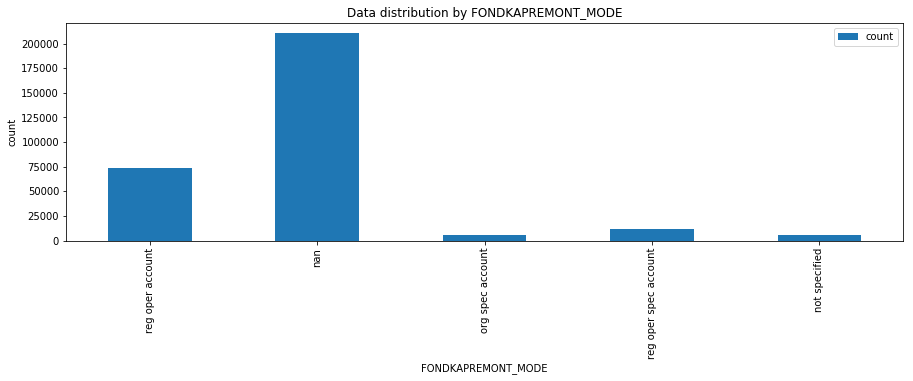

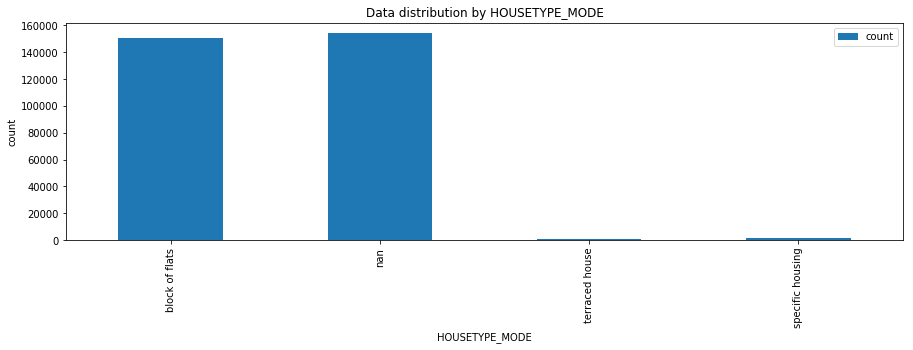

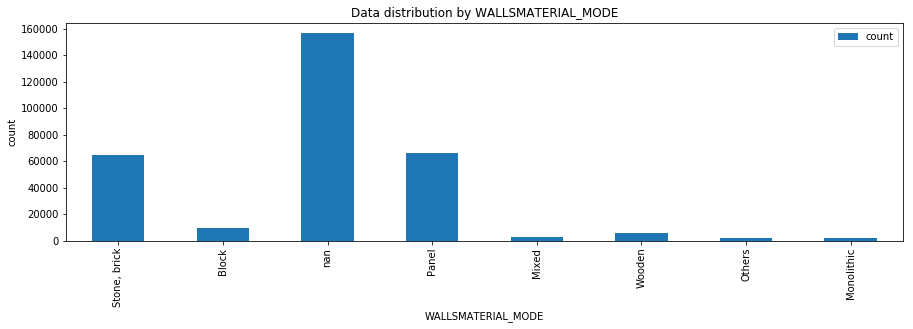

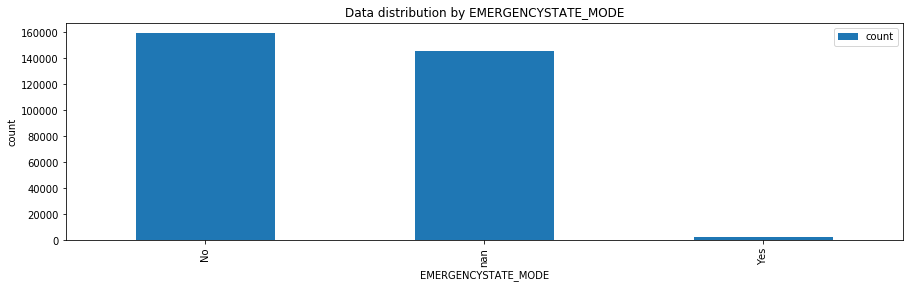

In [71]:
draw_hists_for_categorical_columns(APARTMENT_GROUP_CATEGORICAL, apartment_application)

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


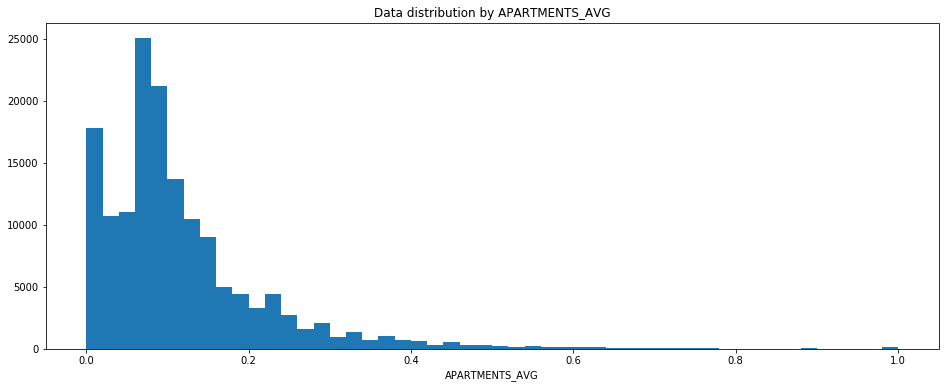

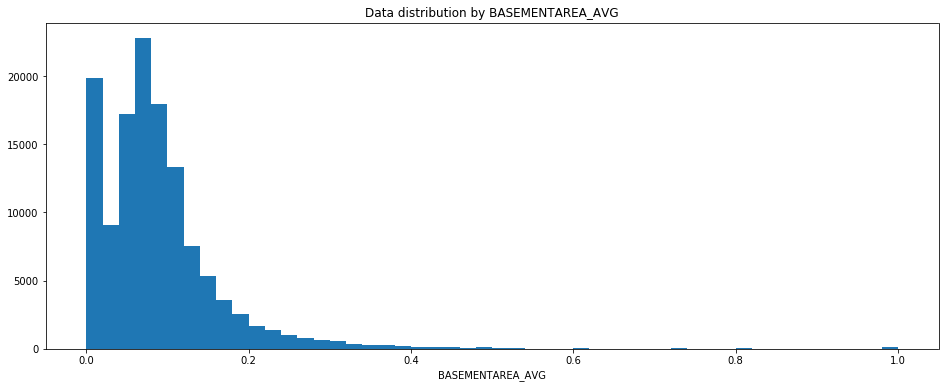

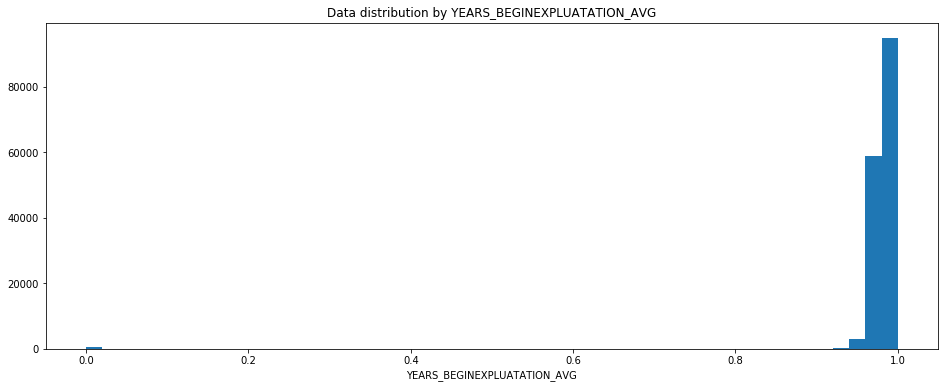

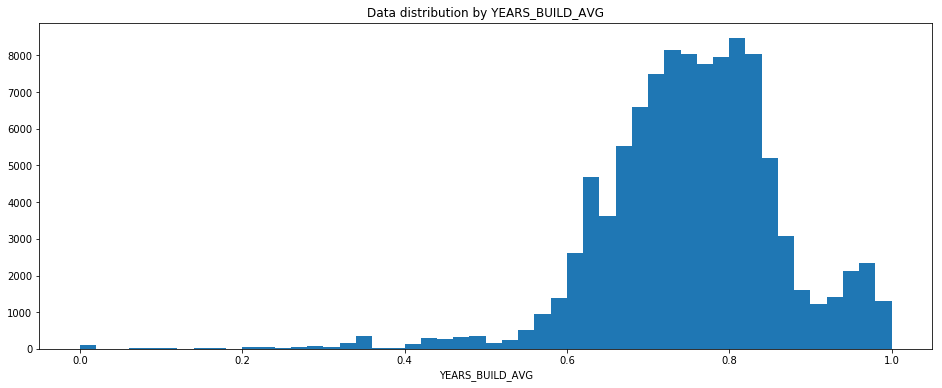

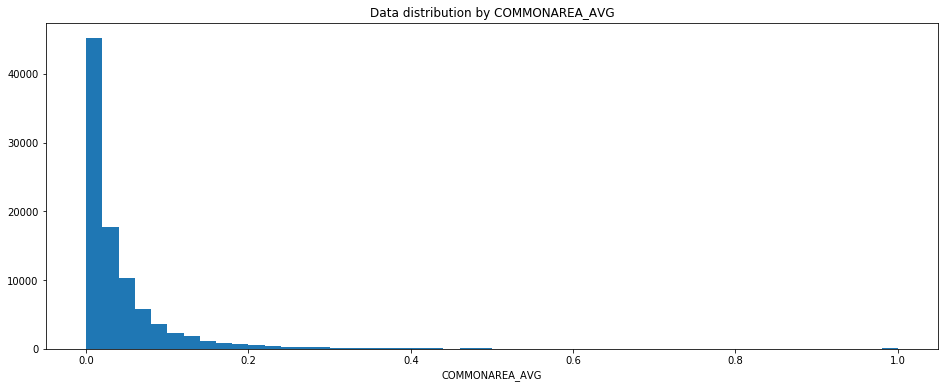

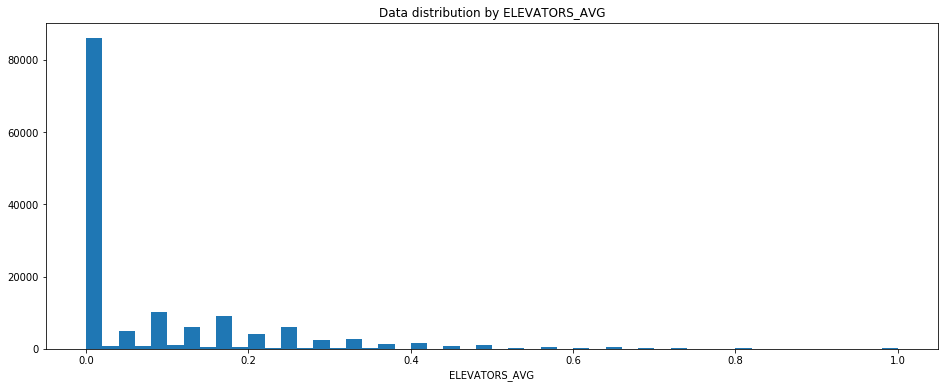

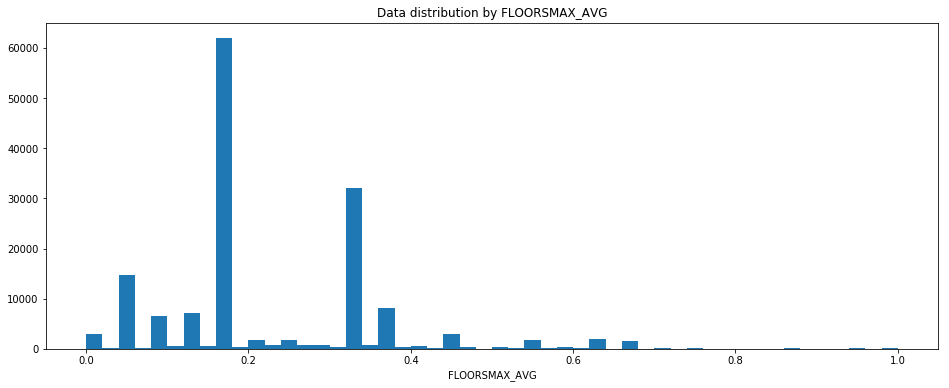

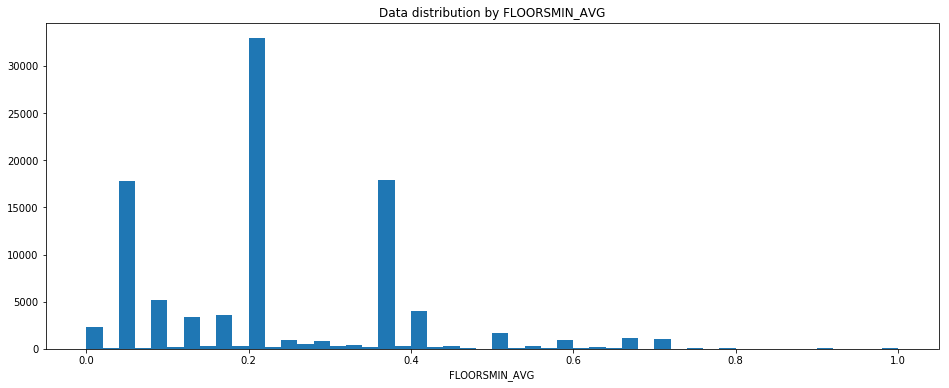

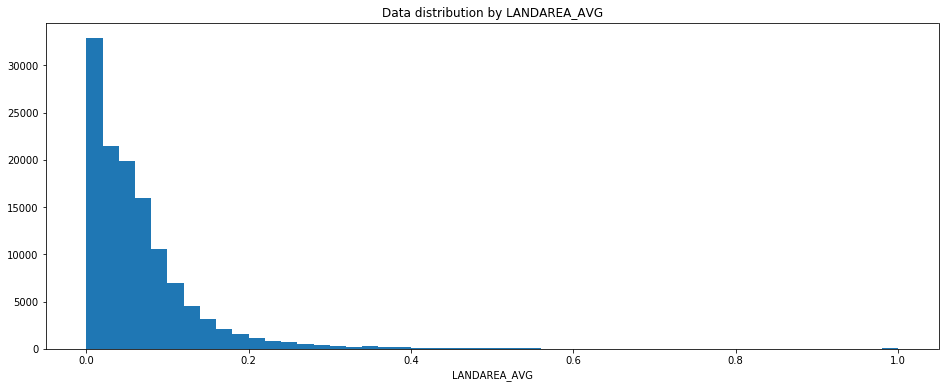

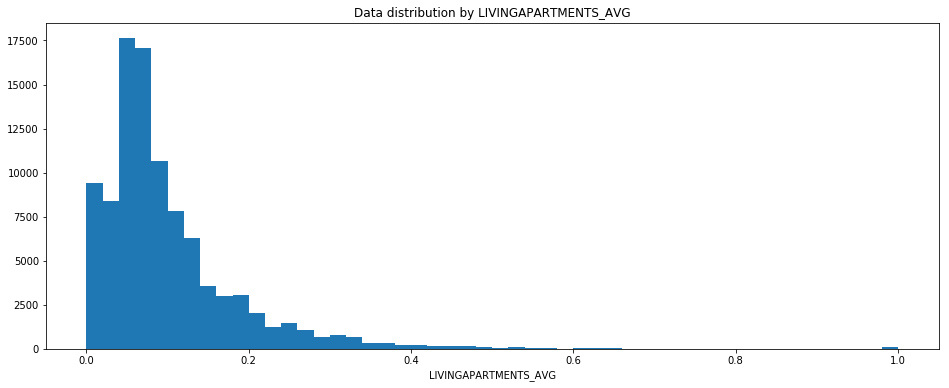

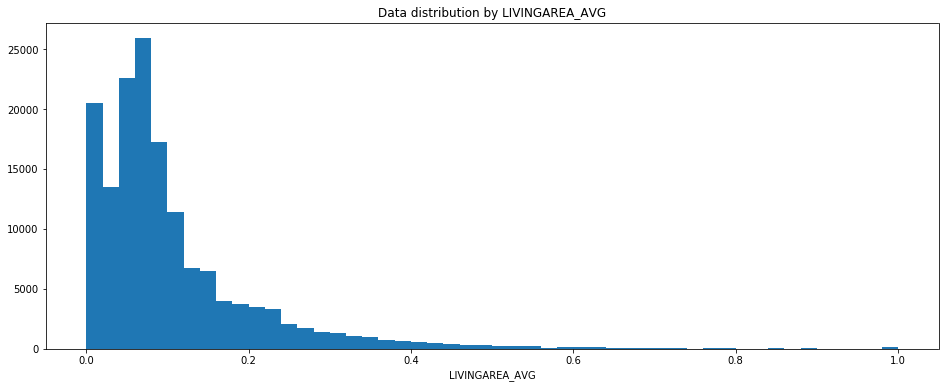

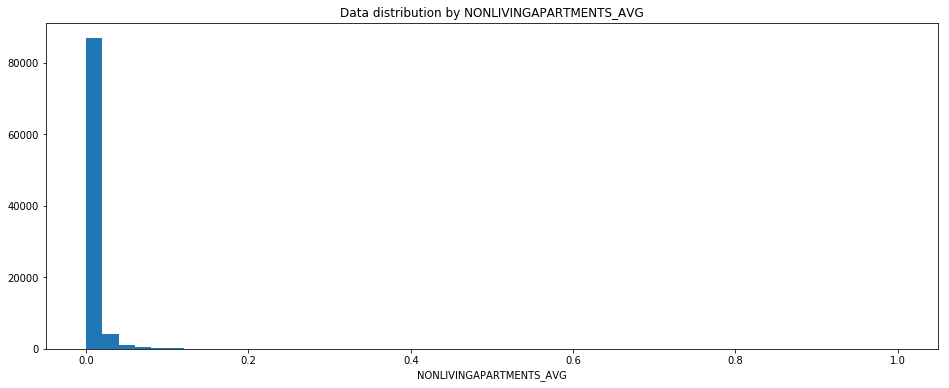

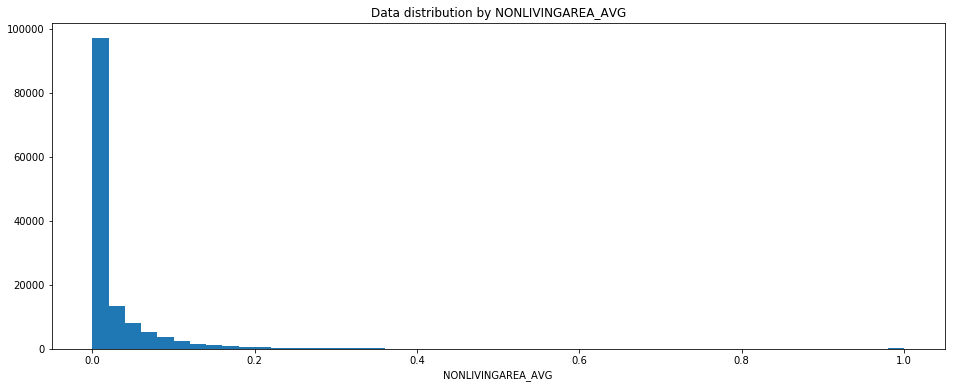

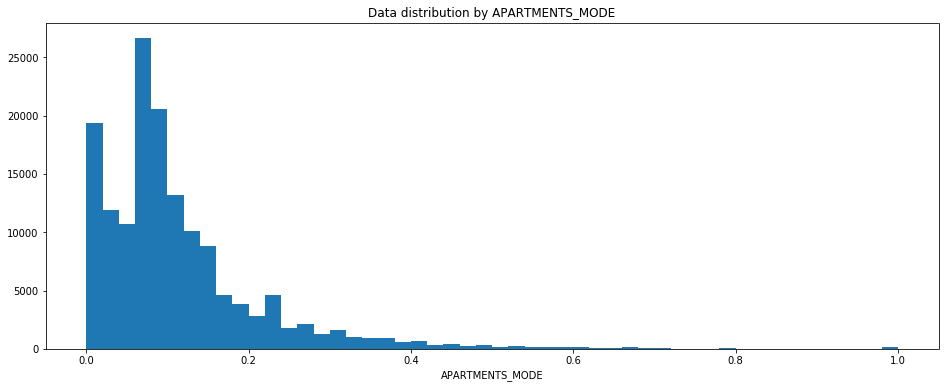

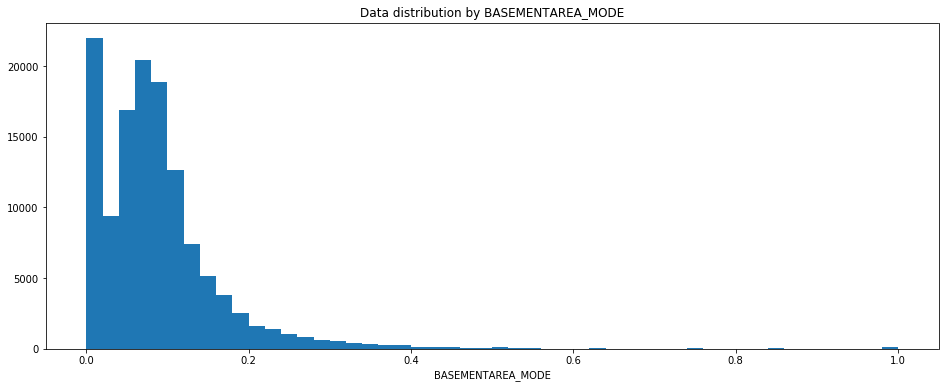

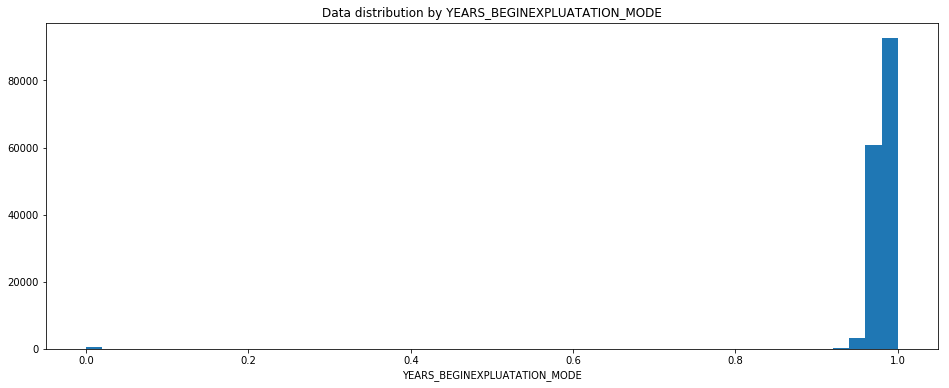

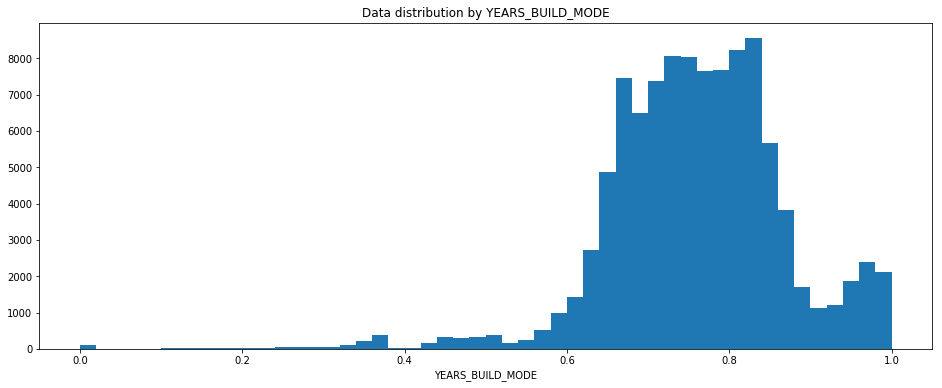

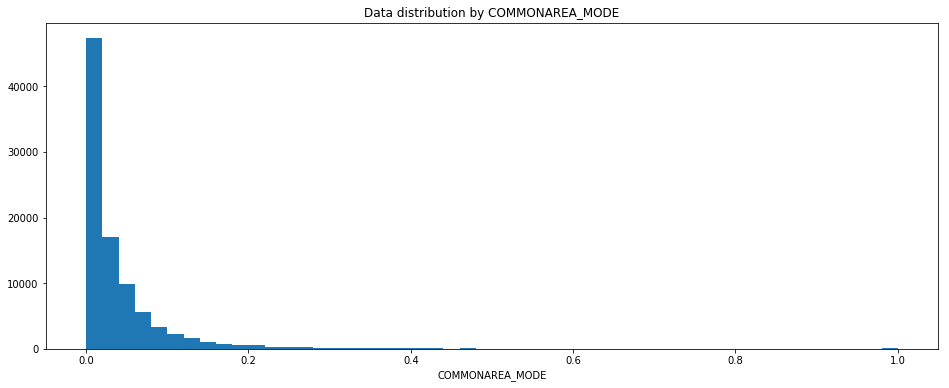

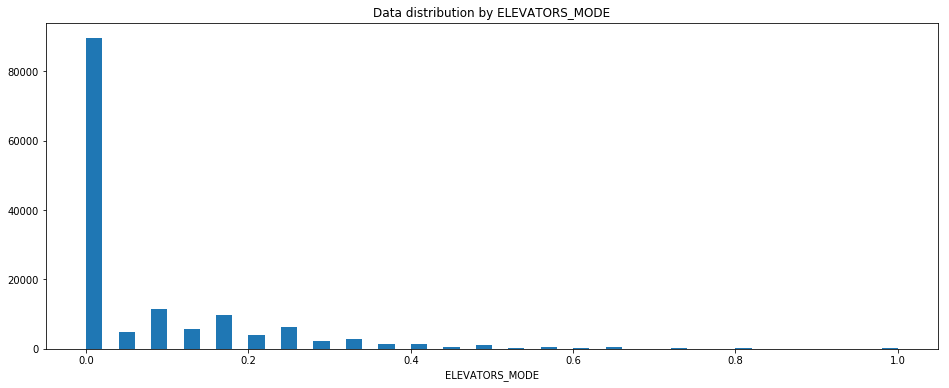

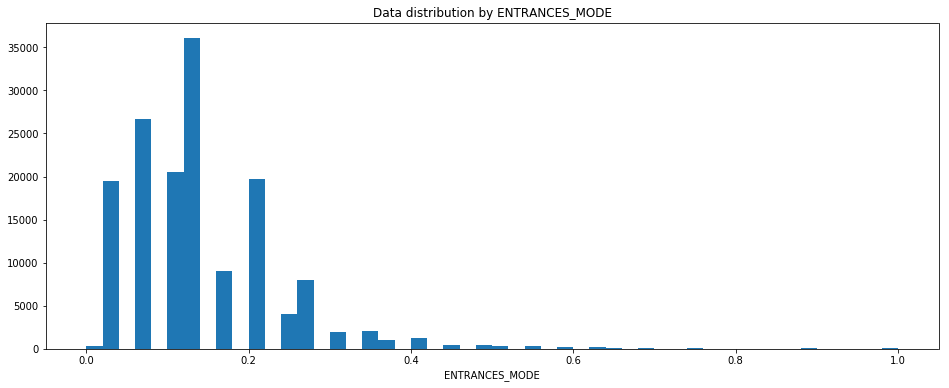

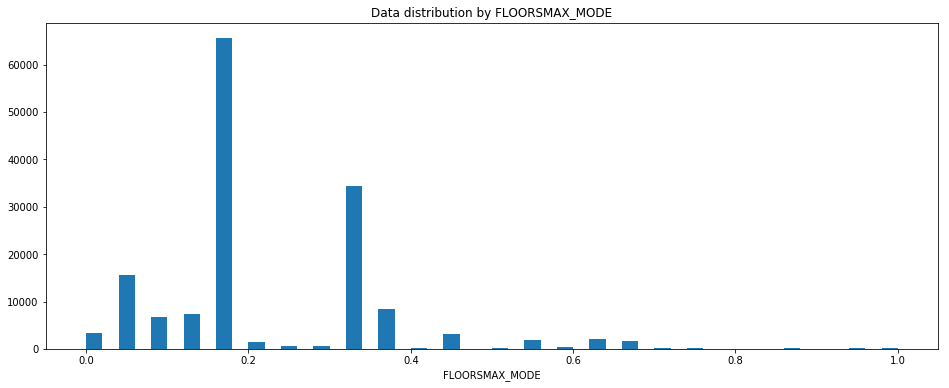

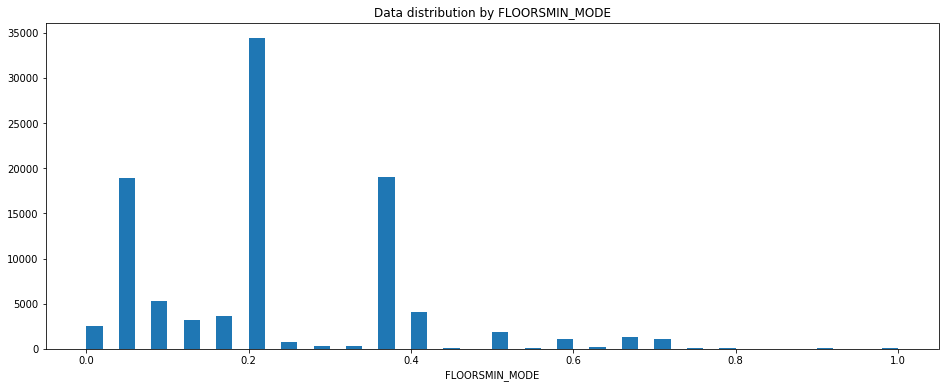

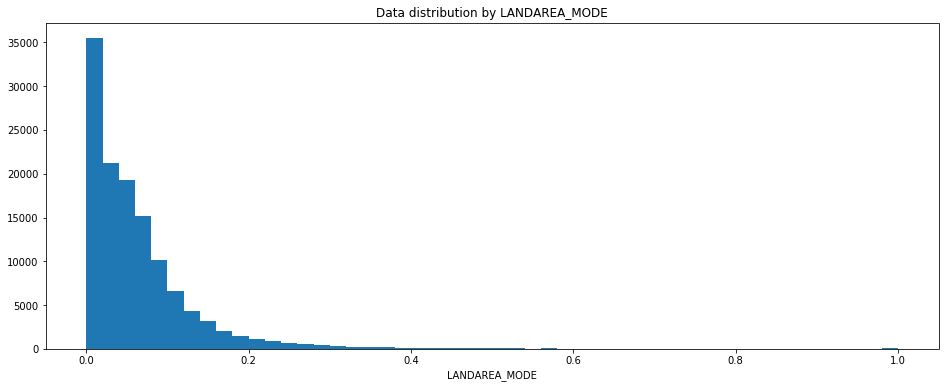

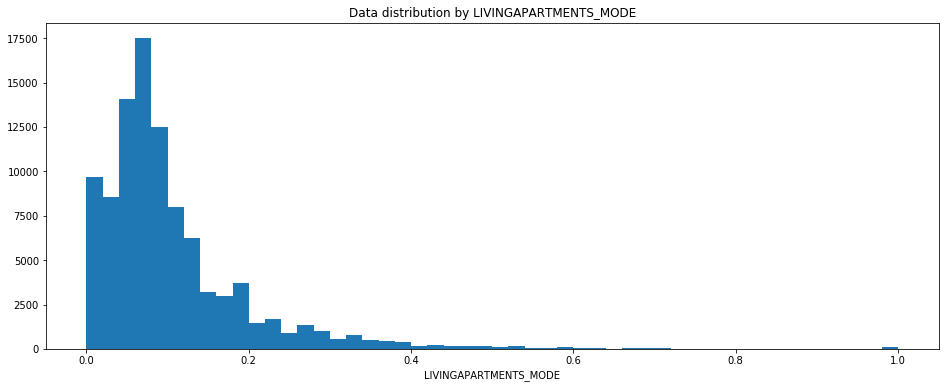

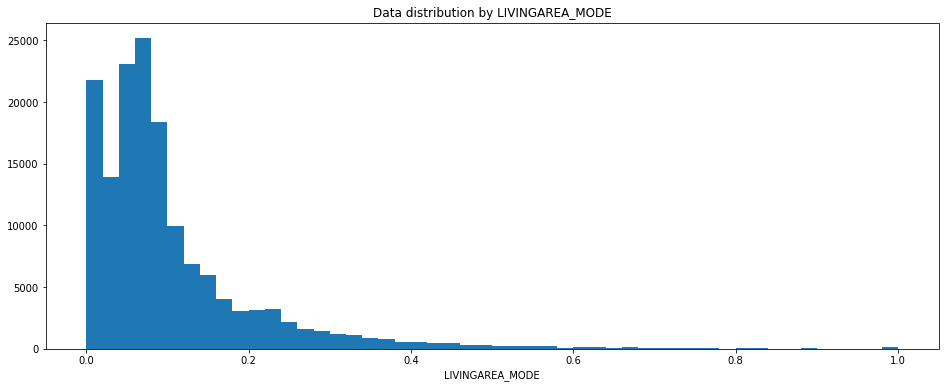

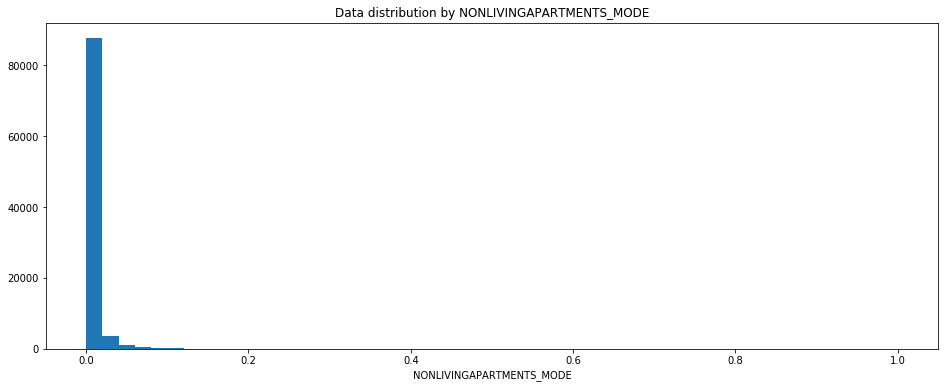

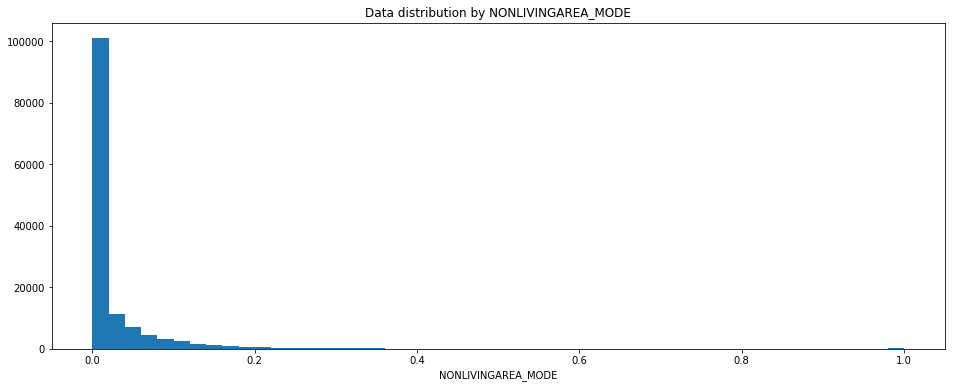

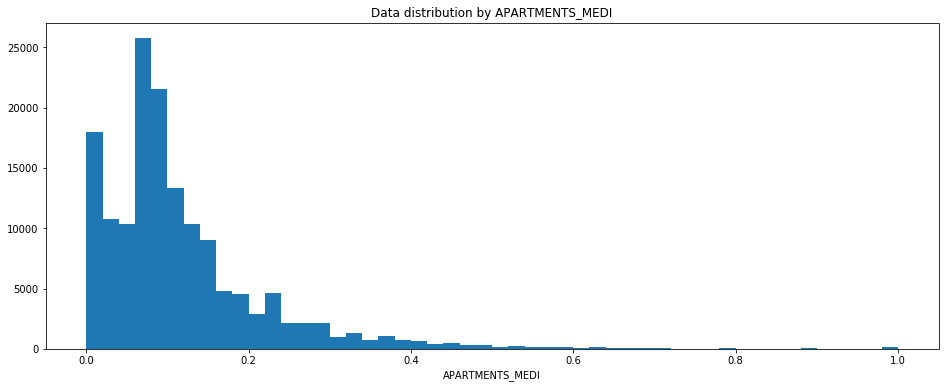

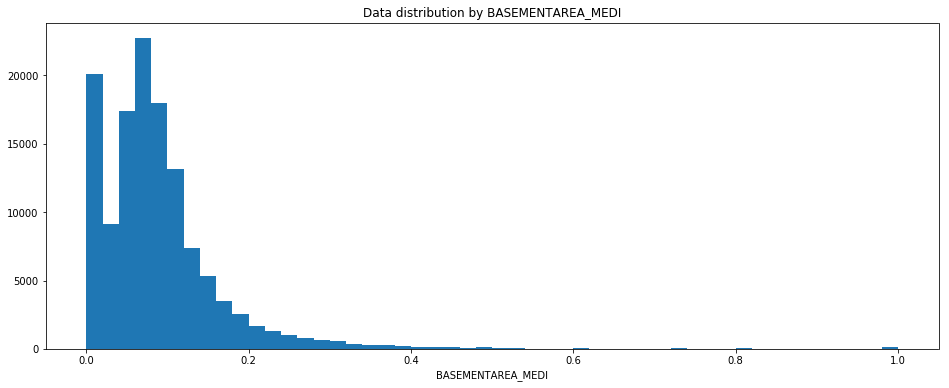

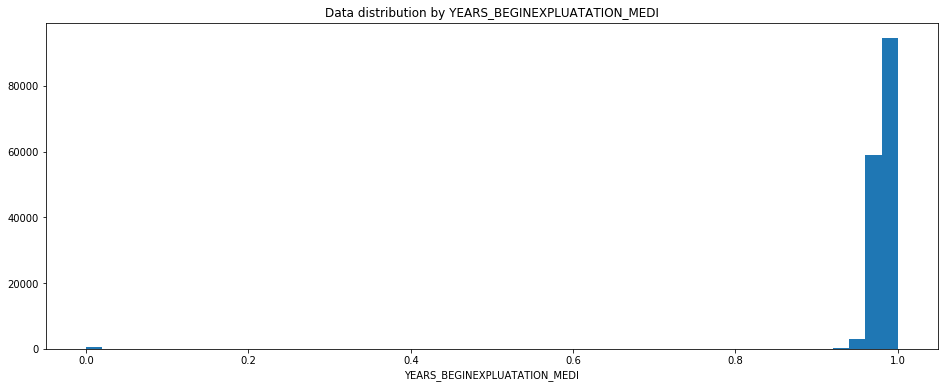

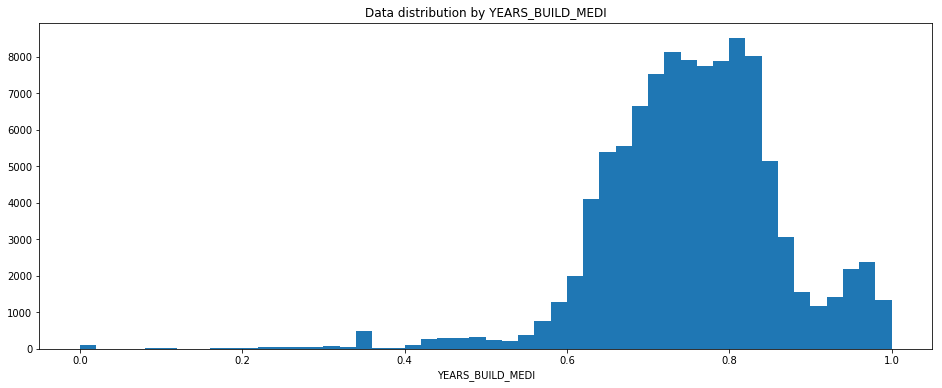

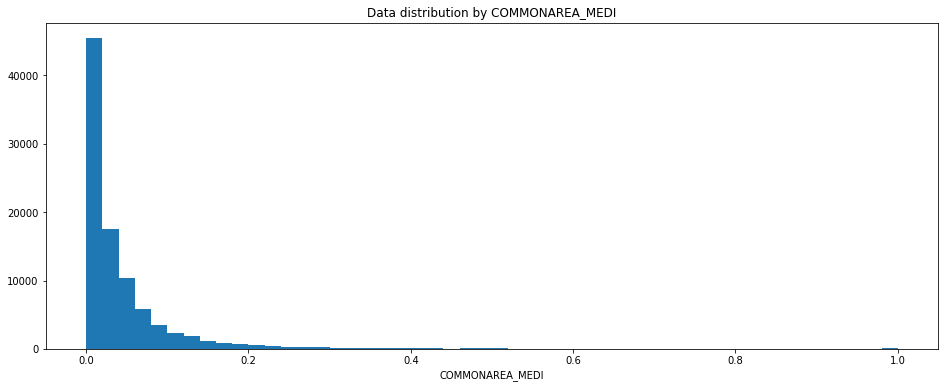

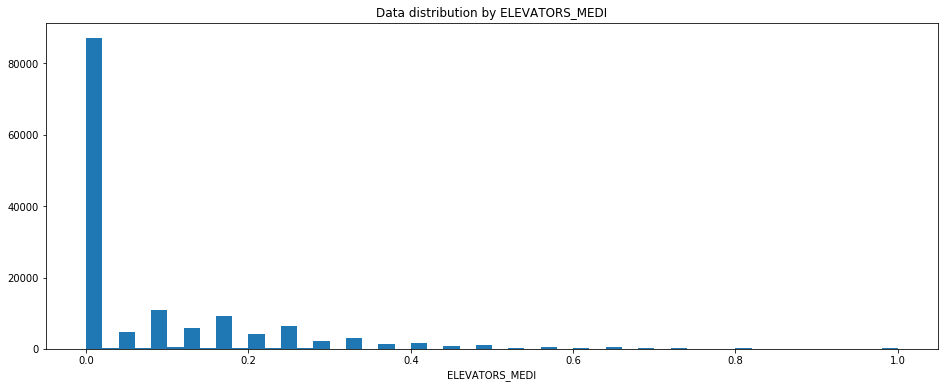

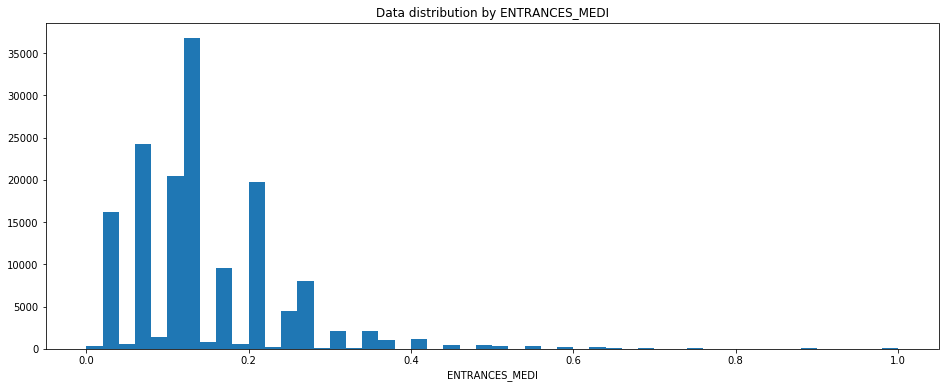

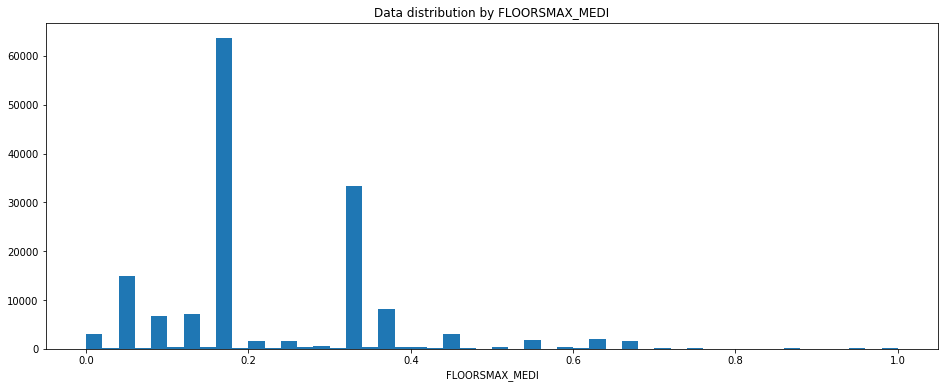

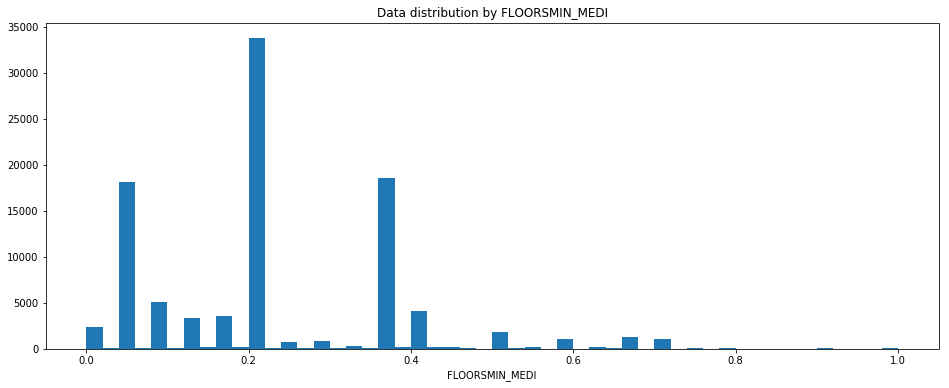

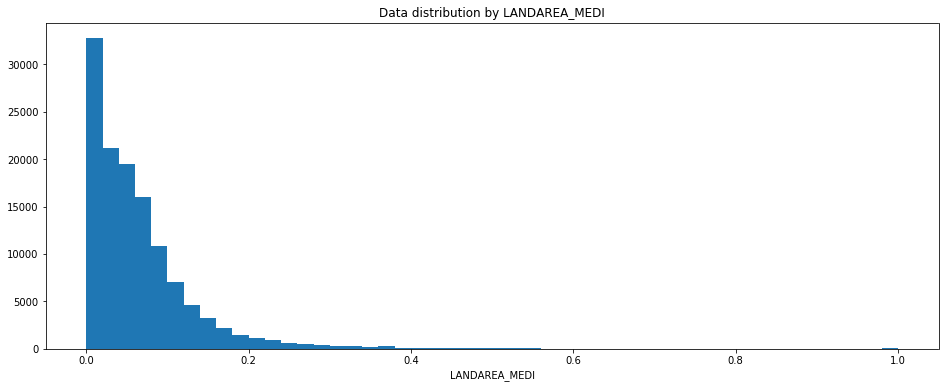

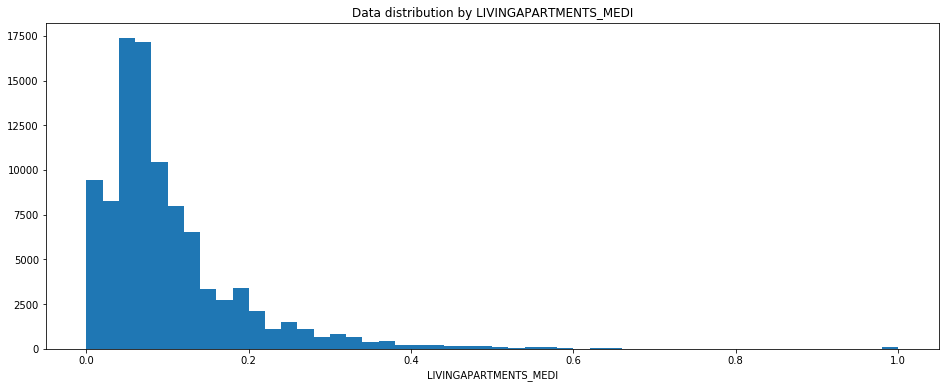

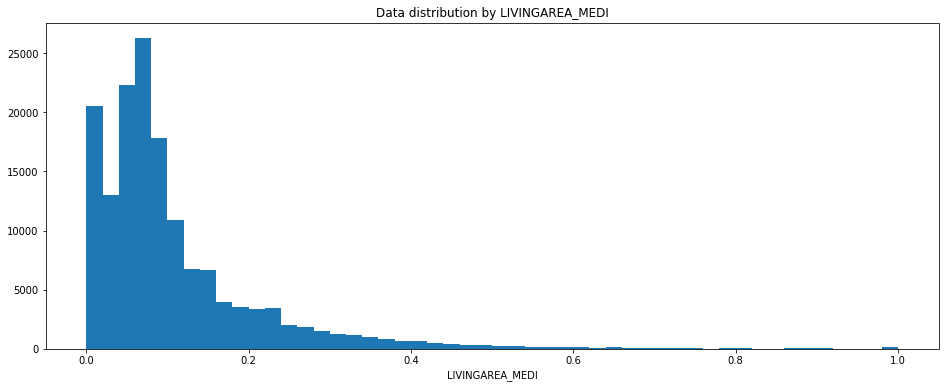

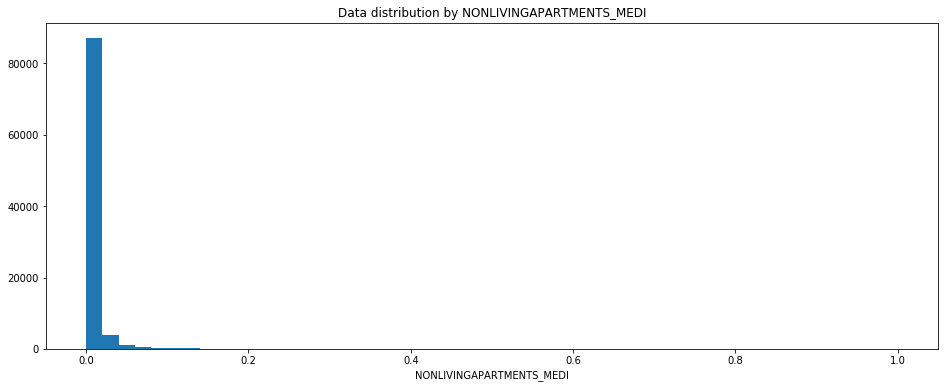

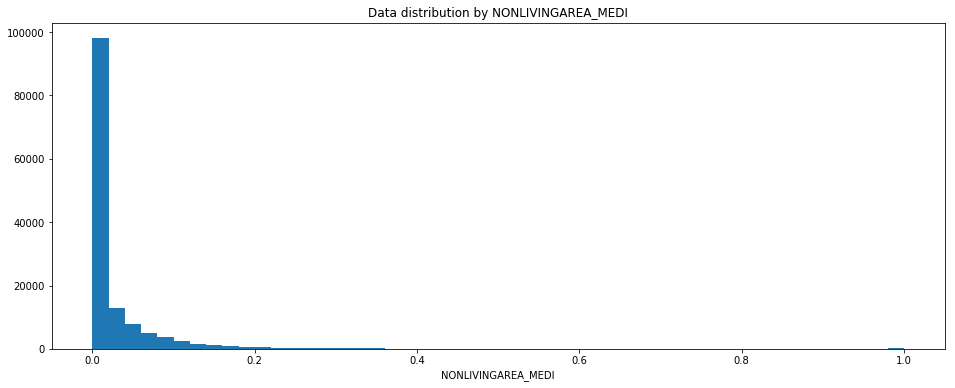

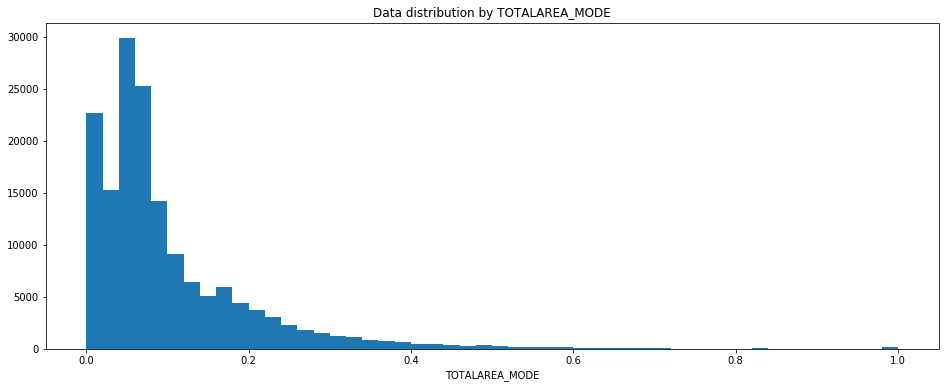

In [72]:
draw_hists_for_numerical_columns(APARTMENT_GROUP_NUMERIC, apartment_application)

## WOE

In [48]:
column_statistics

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
SK_ID_CURR,0,0,307511,1.000020e+05,4.562550e+05,278180.518577,102790.175348,278202.000000
TARGET,0,0,2,0.000000e+00,1.000000e+00,0.080729,0.272419,0.000000
NAME_CONTRACT_TYPE,0,0,2,NaN,NaN,NaN,NaN,NaN
CODE_GENDER,0,0,3,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,0,0,2,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,0,0,2,NaN,NaN,NaN,NaN,NaN
CNT_CHILDREN,0,0,15,0.000000e+00,1.900000e+01,0.417052,0.722121,0.000000
AMT_INCOME_TOTAL,0,0,2548,2.565000e+04,1.170000e+08,168797.919297,237123.146279,147150.000000
AMT_CREDIT,0,0,5603,4.500000e+04,4.050000e+06,599025.999706,402490.776996,513531.000000
AMT_ANNUITY,12,0,13672,1.615500e+03,2.580255e+05,27108.573909,14493.737315,24903.000000


In [49]:
CATEGORICAL_FEATURES = (column_statistics[column_statistics.CountUnique <= 25].index).tolist() + ['ORGANIZATION_TYPE']
NUMERIC_FEATURES = (column_statistics[column_statistics.CountUnique > 25].index).tolist()
NUMERIC_FEATURES.remove('ORGANIZATION_TYPE')

In [50]:
column_statistics[column_statistics.index.isin(CATEGORICAL_FEATURES)]

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
TARGET,0,0,2,0.0,1.0,0.080729,0.272419,0.0000
NAME_CONTRACT_TYPE,0,0,2,NaN,NaN,NaN,NaN,NaN
CODE_GENDER,0,0,3,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,0,0,2,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,0,0,2,NaN,NaN,NaN,NaN,NaN
CNT_CHILDREN,0,0,15,0.0,19.0,0.417052,0.722121,0.0000
NAME_TYPE_SUITE,1292,0,7,NaN,NaN,NaN,NaN,NaN
NAME_INCOME_TYPE,0,0,8,NaN,NaN,NaN,NaN,NaN
NAME_EDUCATION_TYPE,0,0,5,NaN,NaN,NaN,NaN,NaN
NAME_FAMILY_STATUS,0,0,6,NaN,NaN,NaN,NaN,NaN


In [51]:
column_statistics[column_statistics.index.isin(NUMERIC_FEATURES)]

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
SK_ID_CURR,0,0,307511,1.000020e+05,4.562550e+05,278180.518577,102790.175348,278202.000000
AMT_INCOME_TOTAL,0,0,2548,2.565000e+04,1.170000e+08,168797.919297,237123.146279,147150.000000
AMT_CREDIT,0,0,5603,4.500000e+04,4.050000e+06,599025.999706,402490.776996,513531.000000
AMT_ANNUITY,12,0,13672,1.615500e+03,2.580255e+05,27108.573909,14493.737315,24903.000000
AMT_GOODS_PRICE,278,0,1002,4.050000e+04,4.050000e+06,538396.207429,369446.460540,450000.000000
REGION_POPULATION_RELATIVE,0,0,81,2.900000e-04,7.250800e-02,0.020868,0.013831,0.018850
DAYS_BIRTH,0,0,17460,-2.522900e+04,-7.489000e+03,-16036.995067,4363.988632,-15750.000000
DAYS_EMPLOYED,0,0,12574,-1.791200e+04,3.652430e+05,63815.045904,141275.766519,-1213.000000
DAYS_REGISTRATION,0,0,15688,-2.467200e+04,0.000000e+00,-4986.120328,3522.886321,-4504.000000
DAYS_ID_PUBLISH,0,0,6168,-7.197000e+03,0.000000e+00,-2994.202373,1509.450419,-3254.000000


In [52]:

def woe(df):
    target = df['TARGET']
    columns = df.columns
    woe_table = pd.DataFrame(columns=[
        'woe', 'iv', '%target=1', '%target=0', 'min', 'max', 'count', '%_of_data'])
    main_woe_table = pd.DataFrame(columns=[
        'woe', 'iv', '%target=1', '%target=0', 'min', 'max', 'count', '%_of_data'])
    description = df.describe()
    bad_cols = []
    count_1 = df[df.TARGET == 1]['TARGET'].count()
    count_0 = df[df.TARGET == 0]['TARGET'].count()
    for col in columns:
        print('\n', col, end=' ')
        try:
            if col in CATEGORICAL_FEATURES:
                values = np.unique(df[col])
                iv_total = 0
                if len(values) > 50:
                    bad_cols.append(col)
                    print('\n!!!!!', col)
                    continue
                for v in values:
#                     print(v, end=' ')
                    tmp = df[df[col] == v]
                    count = tmp[col].count()
                    tmp_min = tmp[col].min()
                    tmp_max = tmp[col].max()
                    percent_of_data = count / df.shape[0] * 100
                    percent_of_one = tmp[tmp.TARGET == 1][col].count() / count_1 * 100
                    percent_of_zero = tmp[tmp.TARGET == 0][col].count() / count_0 * 100
                    woe = np.log(percent_of_one / percent_of_zero)
                    iv = (percent_of_one - percent_of_zero) * woe
                    woe_table.loc[col + '_%s' % v] = {
                        'woe': woe, 'iv': iv, '%target=1': percent_of_one, '%target=0': percent_of_zero,
                        'min': tmp_min, 'max': tmp_max, 'count': count, '%_of_data': percent_of_data
                    }
                    iv_total += iv
                tmp = df
                count = tmp[col].count()
                tmp_min = tmp[col].min()
                tmp_max = tmp[col].max()
                iv = iv_total
                woe_table.loc[col] = {
                    'woe': None, 'iv': iv, '%target=1': None, '%target=0': None,
                    'min': tmp_min, 'max': tmp_max, 'count': count, '%_of_data': None
                }   
                main_woe_table.loc[col] = {
                    'woe': None, 'iv': iv, '%target=1': None, '%target=0': None,
                    'min': tmp_min, 'max': tmp_max, 'count': count, '%_of_data': None
                }  
            else:  # col in NUMERIC_FEATURES
                b1, b2, b3 = description.loc['25%', col], description.loc['50%', col], description.loc['75%', col]
                iv_total = 0
                old_left = None
                for b in [(df[col].min(), b1), (b1, b2), (b2, b3), (b3, df[col].max())]:
#                     print(b, end=' ')
                    left, right = b
                    if old_left == left:
                        continue
                    old_left = left
                    tmp = df[(df[col] >= left) & (df[col] < right)]
                    count = tmp[col].count()
                    tmp_min = tmp[col].min()
                    tmp_max = tmp[col].max()
                    percent_of_data = count / df.shape[0] * 100
                    percent_of_one = tmp[tmp.TARGET == 1][col].count() / count_1 * 100
                    percent_of_zero = tmp[tmp.TARGET == 0][col].count() / count_0 * 100
                    woe = np.log(percent_of_one / percent_of_zero)
                    iv = (percent_of_one - percent_of_zero) * woe
                    woe_table.loc[col + '_%s_%s' % (left, right)] = {
                        'woe': woe, 'iv': iv, '%target=1': percent_of_one, '%target=0': percent_of_zero,
                        'min': tmp_min, 'max': tmp_max, 'count': count, '%_of_data': percent_of_data
                    }
                    iv_total += iv
                tmp = df
                count = tmp[col].count()
                tmp_min = tmp[col].min()
                tmp_max = tmp[col].max()
                iv = iv_total
                woe_table.loc[col + '_%s_%s' % (left, right)] = {
                    'woe': None, 'iv': iv, '%target=1': None, '%target=0': None,
                    'min': tmp_min, 'max': tmp_max, 'count': count, '%_of_data': None
                }
                main_woe_table.loc[col + '_%s_%s' % (left, right)] = {
                    'woe': None, 'iv': iv, '%target=1': None, '%target=0': None,
                    'min': tmp_min, 'max': tmp_max, 'count': count, '%_of_data': None
                }
        except:
            bad_cols.append(col)
            print('\n!!!!!', col)
                
    return main_woe_table, woe_table, bad_cols



In [53]:
application[application.TARGET == 1]['TARGET'].count()

24825

In [54]:
main_woe_table, woe_table, bad_cols = woe(application)


 SK_ID_CURR 
 TARGET 

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log
/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars



 NAME_CONTRACT_TYPE 
 CODE_GENDER 
 FLAG_OWN_CAR 
 FLAG_OWN_REALTY 
 CNT_CHILDREN 
 AMT_INCOME_TOTAL 
 AMT_CREDIT 
 AMT_ANNUITY 
 AMT_GOODS_PRICE 
 NAME_TYPE_SUITE 
!!!!! NAME_TYPE_SUITE

 NAME_INCOME_TYPE 
 NAME_EDUCATION_TYPE 
 NAME_FAMILY_STATUS 
 NAME_HOUSING_TYPE 
 REGION_POPULATION_RELATIVE 
 DAYS_BIRTH 
 DAYS_EMPLOYED 
 DAYS_REGISTRATION 
 DAYS_ID_PUBLISH 
 OWN_CAR_AGE 
 FLAG_MOBIL 
 FLAG_EMP_PHONE 
 FLAG_WORK_PHONE 
 FLAG_CONT_MOBILE 
 FLAG_PHONE 
 FLAG_EMAIL 
 OCCUPATION_TYPE 
!!!!! OCCUPATION_TYPE

 CNT_FAM_MEMBERS 

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars



 REGION_RATING_CLIENT 
 REGION_RATING_CLIENT_W_CITY 
 WEEKDAY_APPR_PROCESS_START 
 HOUR_APPR_PROCESS_START 
 REG_REGION_NOT_LIVE_REGION 
 REG_REGION_NOT_WORK_REGION 
 LIVE_REGION_NOT_WORK_REGION 
 REG_CITY_NOT_LIVE_CITY 
 REG_CITY_NOT_WORK_CITY 
 LIVE_CITY_NOT_WORK_CITY 
 ORGANIZATION_TYPE 
!!!!! ORGANIZATION_TYPE

 EXT_SOURCE_1 
 EXT_SOURCE_2 
 EXT_SOURCE_3 
 APARTMENTS_AVG 
 BASEMENTAREA_AVG 
 YEARS_BEGINEXPLUATATION_AVG 
 YEARS_BUILD_AVG 
 COMMONAREA_AVG 
 ELEVATORS_AVG 

/Users/juliasemavina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars



 ENTRANCES_AVG 
 FLOORSMAX_AVG 
 FLOORSMIN_AVG 
 LANDAREA_AVG 
 LIVINGAPARTMENTS_AVG 
 LIVINGAREA_AVG 
 NONLIVINGAPARTMENTS_AVG 
 NONLIVINGAREA_AVG 
 APARTMENTS_MODE 
 BASEMENTAREA_MODE 
 YEARS_BEGINEXPLUATATION_MODE 
 YEARS_BUILD_MODE 
 COMMONAREA_MODE 
 ELEVATORS_MODE 
 ENTRANCES_MODE 
 FLOORSMAX_MODE 
!!!!! FLOORSMAX_MODE

 FLOORSMIN_MODE 
!!!!! FLOORSMIN_MODE

 LANDAREA_MODE 
 LIVINGAPARTMENTS_MODE 
 LIVINGAREA_MODE 
 NONLIVINGAPARTMENTS_MODE 
 NONLIVINGAREA_MODE 
 APARTMENTS_MEDI 
 BASEMENTAREA_MEDI 
 YEARS_BEGINEXPLUATATION_MEDI 
 YEARS_BUILD_MEDI 
 COMMONAREA_MEDI 
 ELEVATORS_MEDI 
 ENTRANCES_MEDI 
 FLOORSMAX_MEDI 
 FLOORSMIN_MEDI 
 LANDAREA_MEDI 
 LIVINGAPARTMENTS_MEDI 
 LIVINGAREA_MEDI 
 NONLIVINGAPARTMENTS_MEDI 
 NONLIVINGAREA_MEDI 
 FONDKAPREMONT_MODE 
!!!!! FONDKAPREMONT_MODE

 HOUSETYPE_MODE 
!!!!! HOUSETYPE_MODE

 TOTALAREA_MODE 
 WALLSMATERIAL_MODE 
!!!!! WALLSMATERIAL_MODE

 EMERGENCYSTATE_MODE 
!!!!! EMERGENCYSTATE_MODE

 OBS_30_CNT_SOCIAL_CIRCLE 
 DEF_30_CNT_SOCIAL_C

In [55]:
main_woe_table

,woe,iv,%target=1,%target=0,min,max,count,%_of_data
SK_ID_CURR_367142.5_456255,NaN,0.027894,NaN,NaN,100002,456255,307511.0,NaN
TARGET,NaN,inf,NaN,NaN,0,1,307511.0,NaN
NAME_CONTRACT_TYPE,None,1.503877,None,None,Cash loans,Revolving loans,307511.0,None
CODE_GENDER,None,inf,None,None,F,XNA,307511.0,None
FLAG_OWN_CAR,None,0.659655,None,None,N,Y,307511.0,None
FLAG_OWN_REALTY,None,0.050545,None,None,N,Y,307511.0,None
CNT_CHILDREN,NaN,inf,NaN,NaN,0,19,307511.0,NaN
AMT_INCOME_TOTAL_202500.0_117000000.0,NaN,0.695619,NaN,NaN,25650,1.17e+08,307511.0,NaN
AMT_CREDIT_808650.0_4050000.0,NaN,2.987689,NaN,NaN,45000,4.05e+06,307511.0,NaN
AMT_ANNUITY_34596.0_258025.5,NaN,1.577401,NaN,NaN,1615.5,258026,307499.0,NaN


По iv бесполезными признаками являются:

In [56]:
main_woe_table[main_woe_table['iv'] < 0.02]

,woe,iv,%target=1,%target=0,min,max,count,%_of_data
FLAG_CONT_MOBILE,NaN,0.000187,NaN,NaN,0,1,307511.0,NaN
FLAG_EMAIL,NaN,0.004210,NaN,NaN,0,1,307511.0,NaN
LIVE_REGION_NOT_WORK_REGION,NaN,0.010502,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_5,NaN,0.000135,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_7,NaN,0.003819,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_19,NaN,0.002727,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_20,NaN,0.000062,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_21,NaN,0.014527,NaN,NaN,0,1,307511.0,NaN


слабые:

In [57]:
main_woe_table[(main_woe_table['iv'] >= 0.02) & (main_woe_table['iv'] < 0.1)]

,woe,iv,%target=1,%target=0,min,max,count,%_of_data
SK_ID_CURR_367142.5_456255,NaN,0.027894,NaN,NaN,100002,456255,307511.0,NaN
FLAG_OWN_REALTY,None,0.050545,None,None,N,Y,307511.0,None
WEEKDAY_APPR_PROCESS_START,None,0.067669,None,None,FRIDAY,WEDNESDAY,307511.0,None
REG_REGION_NOT_LIVE_REGION,NaN,0.039302,NaN,NaN,0,1,307511.0,NaN
REG_REGION_NOT_WORK_REGION,NaN,0.062277,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_2,NaN,0.020967,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_8,NaN,0.090633,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_9,NaN,0.028773,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_11,NaN,0.027059,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_15,NaN,0.088341,NaN,NaN,0,1,307511.0,NaN


средние:

In [58]:
main_woe_table[(main_woe_table['iv'] >= 0.1) & (main_woe_table['iv'] < 0.3)]

,woe,iv,%target=1,%target=0,min,max,count,%_of_data
FLAG_DOCUMENT_13,NaN,0.284563,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_14,NaN,0.176724,NaN,NaN,0,1,307511.0,NaN
FLAG_DOCUMENT_16,NaN,0.225995,NaN,NaN,0,1,307511.0,NaN


сильные

In [59]:
main_woe_table[(main_woe_table['iv'] >= 0.3) & (main_woe_table['iv'] < 0.5)]

,woe,iv,%target=1,%target=0,min,max,count,%_of_data


очень сильные

In [60]:
main_woe_table[main_woe_table['iv'] >= 0.5]

,woe,iv,%target=1,%target=0,min,max,count,%_of_data
TARGET,NaN,inf,NaN,NaN,0,1,307511.0,NaN
NAME_CONTRACT_TYPE,None,1.503877,None,None,Cash loans,Revolving loans,307511.0,None
CODE_GENDER,None,inf,None,None,F,XNA,307511.0,None
FLAG_OWN_CAR,None,0.659655,None,None,N,Y,307511.0,None
CNT_CHILDREN,NaN,inf,NaN,NaN,0,19,307511.0,NaN
AMT_INCOME_TOTAL_202500.0_117000000.0,NaN,0.695619,NaN,NaN,25650,1.17e+08,307511.0,NaN
AMT_CREDIT_808650.0_4050000.0,NaN,2.987689,NaN,NaN,45000,4.05e+06,307511.0,NaN
AMT_ANNUITY_34596.0_258025.5,NaN,1.577401,NaN,NaN,1615.5,258026,307499.0,NaN
AMT_GOODS_PRICE_679500.0_4050000.0,NaN,4.542897,NaN,NaN,40500,4.05e+06,307233.0,NaN
NAME_INCOME_TYPE,None,inf,None,None,Businessman,Working,307511.0,None


In [61]:
woe_table

,woe,iv,%target=1,%target=0,min,max,count,%_of_data
SK_ID_CURR_100002_189145.5,-0.00602197,0.00090432,24.862,25.0122,100002,189145,76878,25.0001
SK_ID_CURR_189145.5_278202.0,0.0282018,0.0201199,25.6556,24.9422,189146,278201,76877,24.9998
SK_ID_CURR_278202.0_367142.5,-0.00813783,0.00164997,24.8137,25.0164,278202,367142,76878,25.0001
SK_ID_CURR_367142.5_456255,woe,iv,%target=1,%target=0,min,max,count,%_of_data
TARGET_0,-inf,inf,0,100,0,0,282686,91.9271
TARGET_1,inf,inf,100,0,1,1,24825,8.07288
TARGET,NaN,inf,NaN,NaN,0,1,307511,NaN
NAME_CONTRACT_TYPE_Cash loans,0.0362359,0.120622,93.5388,90.21,Cash loans,Cash loans,278232,90.4787
NAME_CONTRACT_TYPE_Revolving loans,-0.415543,1.38326,6.46123,9.79001,Revolving loans,Revolving loans,29279,9.52129
NAME_CONTRACT_TYPE,None,1.50388,None,None,Cash loans,Revolving loans,307511,None


In [62]:
bad_cols

['NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [63]:
get_df_general_stats(application[bad_cols])

,CountNaN,RateNaN%,CountUnique,MinValue,MaxValue,Mean,Std,Median
NAME_TYPE_SUITE,1292,0,7,NaN,NaN,NaN,NaN,NaN
OCCUPATION_TYPE,96391,31,18,NaN,NaN,NaN,NaN,NaN
ORGANIZATION_TYPE,0,0,58,NaN,NaN,NaN,NaN,NaN
FLOORSMAX_MODE,153020,49,25,0.0,1.0,0.222315,0.143709,0.1667
FLOORSMIN_MODE,208642,67,25,0.0,1.0,0.228058,0.161160,0.2083
FONDKAPREMONT_MODE,210295,68,4,NaN,NaN,NaN,NaN,NaN
HOUSETYPE_MODE,154297,50,3,NaN,NaN,NaN,NaN,NaN
WALLSMATERIAL_MODE,156341,50,7,NaN,NaN,NaN,NaN,NaN
EMERGENCYSTATE_MODE,145755,47,2,NaN,NaN,NaN,NaN,NaN
DEF_30_CNT_SOCIAL_CIRCLE,1021,0,10,0.0,34.0,0.143421,0.446698,0.0000
